Some functions that will be used in the notebook

In [17]:
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
#This is used numerous times throughout the notebook to generate the roc_auc scores easily 
#The roc_auc scores are calculated in order to be plotted
#source: Ignacio Garcia
def calculate_roc(model, X, y):
    
    y_pred = model.predict(X)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y, y_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    return roc_auc

#This method creates a "y" dataset with multilabel format instead of the original with each intention separated
#source: Ignacio Garcia
def creating_multilabel(y):
    
    labels = [None] * len(y.index)

    #output = pandas.DataFrame.to_dict(output)

    for intention in intentions:

        offset = 0

        for line in y[intention]:

            if labels[offset] == None:
                labels[offset] = []
            if line == 1:
                labels[offset].append(str(intention))

            offset += 1

    return labels

#source: https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(12, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

The purpose of this notebook is to perform a in-deep analysis of the dataset in order to create a predictive model to assign intentions to each revision of an article. 
The intentions can be divided in 14 different categories that range from vandalism to point of view. Due to this reason this problem can be approached with a multilabel focus or from a binary perspective by creating a model for each intention.
A dual approach is used: multilabel classification and binary classification. On the one hand the multilabel classification is the easier approach due to the need of only 1 model, however, the capability of fine-tuning a model for each intention might give a higher chance of having better predictions. 
However, the expectations are limited for 2 reasons: first of all the precision and recall score of the model developed by the authors of "Identifying semantic edit intentions from revisions in wikipedia" and the fact that as stated by Daxenberger and Gurevych (2013) predicting intentions based on a 14-category division is more challenging than classifiying low level syntactic actions.

# Data analysis

The first step is to perform an exploratory analysis of the dataset to observe the different labels (intentions), the structure of the data, proportion of the labels... After studying the perks of the dataset, we proceed to the generation of the different models in search of the most optimum one.

In [18]:
import pandas
import numpy as np
import seaborn as sns
import warnings; warnings.simplefilter('ignore')
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from imblearn.over_sampling import ADASYN
from sklearn.datasets import make_classification
from sklearn.metrics import roc_curve, auc
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from imblearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler  

#Load of the dataset and split in training and test set
dataset = pandas.read_csv('data/edit_intention_dataset_featured.csv', sep=',')
X, y = dataset.iloc[:, :-14], dataset.iloc[:, -14:]
kwargs = dict(test_size=0.2, random_state=1)
#Figures size
plt.rcParams['savefig.dpi'] = 100




First of all we create a list with the different intentions available in the dataset.

In [19]:
#Array with the name of the intentions for future use
intentions = ['counter-vandalism','fact-update','refactoring','copy-editing','other','wikification',
            'vandalism','simplification','elaboration','verifiability','process','clarification','disambiguation',
            'point-of-view']

In [20]:
print("Number of rows in data =",dataset.shape[0])
print("Number of columns in data =",dataset.shape[1])
print("Number of NULL values in data =", dataset.isnull().values.any())
print("\n")
print("Data sample")
#Remember that printing the method head() generates the ugliest table
dataset.head(n = 10)



Number of rows in data = 5683
Number of columns in data = 222
Number of NULL values in data = False


Data sample


,feats_0,feats_1,feats_2,feats_3,feats_4,feats_5,feats_6,feats_7,feats_8,feats_9,...,other,wikification,vandalism,simplification,elaboration,verifiability,process,clarification,disambiguation,point-of-view
0,710764506,0.0,0.0,-1.0,0.0,3.0,5.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
1,711588802,0.0,0.0,-1.0,0.0,9.0,10.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
2,709526386,0.0,0.0,-1.0,0.0,326.0,269.0,0.0,0.0,24.0,...,0,0,0,0,0,0,0,0,0,0
3,713098731,0.0,0.0,-1.0,0.0,190.0,0.0,8.0,0.0,7.0,...,0,0,0,0,0,1,0,0,0,0
4,713936284,0.0,0.0,-1.0,0.0,65.0,35.0,0.0,4.0,0.0,...,0,0,0,0,0,1,0,0,0,0
5,710197768,0.0,0.0,-1.0,1.0,886.0,3861.0,14.0,33.0,135.0,...,0,0,0,0,0,0,0,0,0,0
6,709472909,0.0,0.0,-1.0,0.0,0.0,67.0,0.0,0.0,0.0,...,0,1,0,0,0,0,0,0,0,0
7,713345346,0.0,0.0,-1.0,1.0,404.0,80.0,6.0,3.0,61.0,...,0,0,0,0,1,0,0,0,0,0
8,713296089,0.0,0.0,-1.0,0.0,261.0,0.0,4.0,0.0,19.0,...,0,0,0,0,1,1,0,0,0,0
9,709427366,0.0,0.0,-1.0,0.0,35.0,0.0,4.0,0.0,3.0,...,0,1,0,0,0,0,0,0,0,0


As we can see each attribute name gives little to no information about what it is actually measuring. The data is composed of floats for the attributes and binary values for the differente labels. 

After seeing the great range of values of the attributes, it is necessary to scale the data in order to be able to use it as input for algorithms like Nearest Neighbors or SVM. In the case of the random forest it is not needed as it can naturally deal with unscaled data. Standard Scaler is used for this task, scaling the attributes in a fashion that creates a mean of 0 and a variation based on the standard deviation.

In [21]:
#RF doesnt need it but SVC does
feature_scaler = StandardScaler()  
X_scaled = feature_scaler.fit_transform(X)

In [22]:
print("Data sample after scaling")
#Remember that printing the method head() generates the ugliest table
X_scaled.view()


Data sample after scaling


array([[-0.85750114, -0.01876301,  0.        , ..., -0.21401199,
        -0.09773026, -0.09510989],
       [-0.80448349, -0.01876301,  0.        , ..., -0.21401199,
        -0.09773026, -0.09510989],
       [-0.93713541, -0.01876301,  0.        , ..., -0.21401199,
        -0.09773026, -0.09510989],
       ...,
       [ 1.26351233, -0.01876301,  0.        , ..., -0.21401199,
        -0.09773026, -0.09510989],
       [ 1.13877676, -0.01876301,  0.        , ..., -0.21401199,
        -0.09773026, -0.09510989],
       [ 1.23147358, -0.01876301,  0.        , ..., -0.21401199,
        -0.09773026, -0.09510989]])

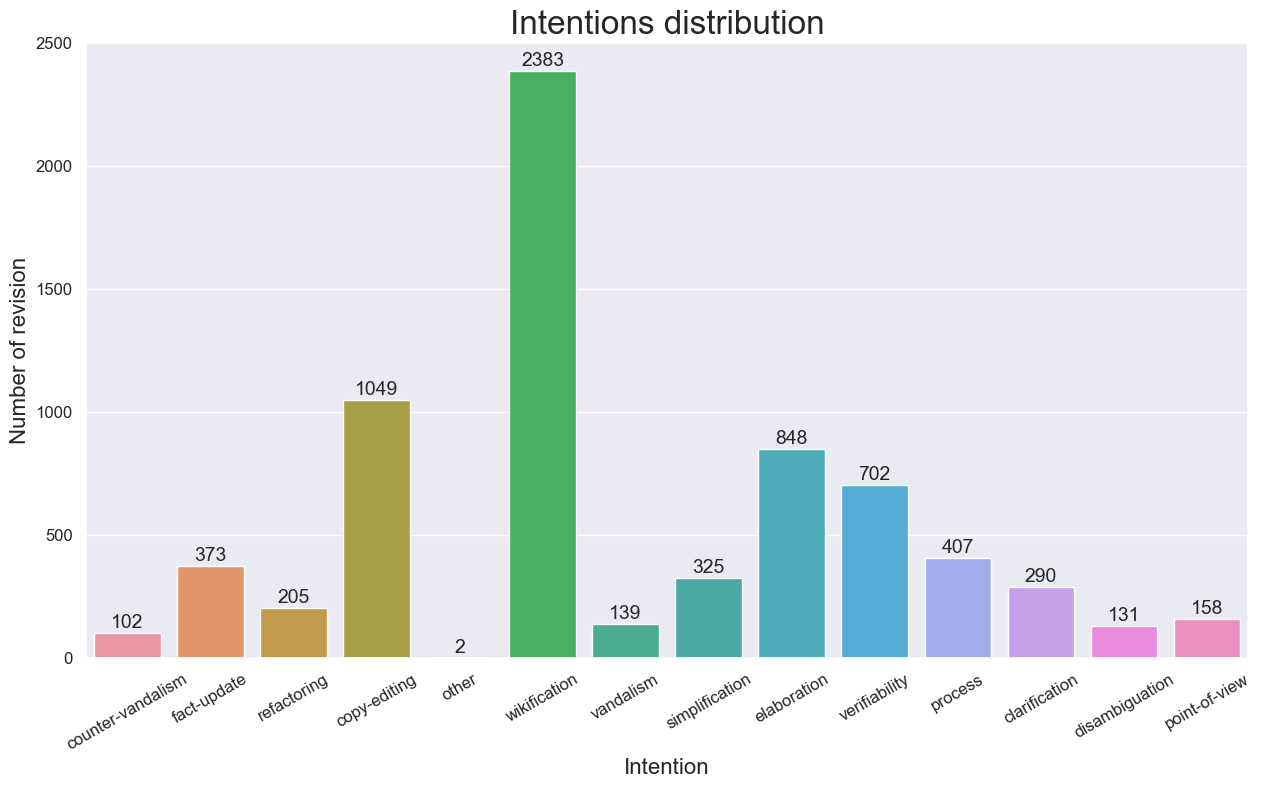

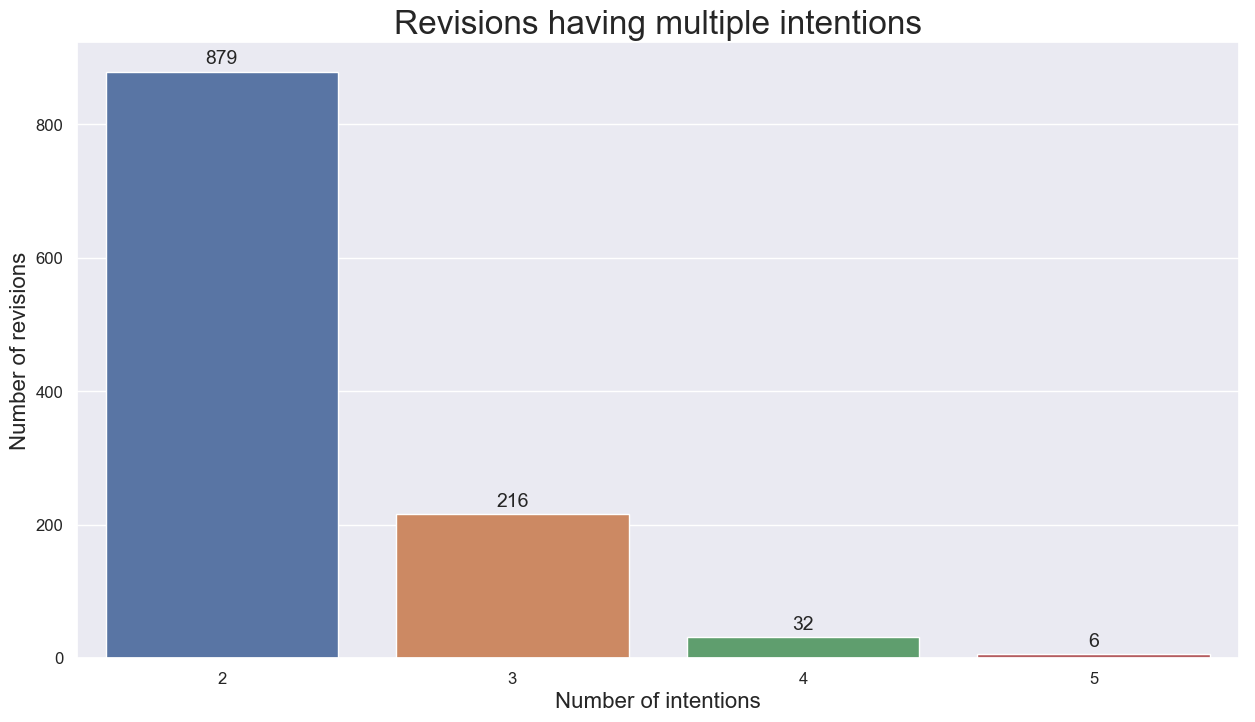

In [23]:
categories = dataset.iloc[:,-14:].columns
sns.set(font_scale = 2)
plt.figure(figsize=(15,8))
ax= sns.barplot(categories, dataset.iloc[:,-14:].sum().values)
plt.title("Intentions distribution", fontsize=24)
plt.ylabel('Number of revision', fontsize=16)
plt.xlabel('Intention', fontsize=16)
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(12) 
    # specify integer or string like 'vertical'
    tick.label.set_rotation(30)
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(12) 
#adding the text labels
rects = ax.patches
labels = dataset.iloc[:,-14:].sum().values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom', fontsize = 14)
#plt.xticks(intentions,rotation = 30)

plt.show()

rowSums = dataset.iloc[:,-14:].sum(axis=1)
multiLabel_counts = rowSums.value_counts()
multiLabel_counts = multiLabel_counts.iloc[1:]
sns.set(font_scale = 2)
plt.figure(figsize=(15,8))
ax = sns.barplot(multiLabel_counts.index, multiLabel_counts.values)
plt.title("Revisions having multiple intentions")
plt.ylabel('Number of revisions', fontsize=16)
plt.xlabel('Number of intentions', fontsize=16)
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(12)
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(12) 
#plt.xticks(multiLabel_counts.index, fontsize = 12)
#adding the text labels
rects = ax.patches
labels = multiLabel_counts.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom', fontsize = 14)
plt.show()

The dataset is clearly inbalanced, having some classes with way more representation than other as it is the case of Wikification. Others like Other only appear twice in the dataset. In some way Other could be even considered an outlier and its usefulness is not clear as it just implies that none of the other intentions appear in a given revision. Furthermore the intentions are not mutually exclusive having 879 revisions with 2 different intentions. However the number of revisions with multiple intentions decrease exponentially as the number of intentions per revision increases having only 6 revisions with 5 intentions. 

Proporción de labels en el dataset


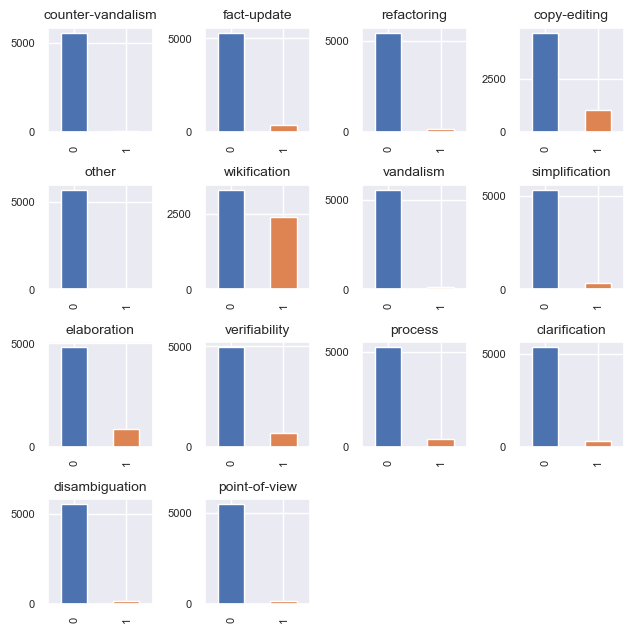

In [24]:
#Charts of the label proportions in the original dataset
print("Proporción de labels en el dataset")
i = 1

for intention in intentions:
    df = pandas.DataFrame(X)
    df['target'] = y[intention]
    plt.subplot(4, 4 , i)
    plt.title(label=intention, fontsize = 10)
    df.target.value_counts().plot(kind='bar');
    plt.xticks(fontsize = 8)
    plt.yticks(fontsize = 8)
    i += 1
plt.subplots_adjust(left=.3, bottom=0.3, right= 1.2, top=1.5, wspace=0.5, hspace=0.5)
plt.show()



Seeing each intention separately allows for better viewing of the lack of balance in the dataset. This will probably bring issues in the binary approach making the use of oversampling a need.

In [25]:
rowSums = dataset.iloc[:,-14:].sum(axis=0)
proportions = []
for intention in intentions:
    proportions.append(rowSums[intention]/dataset.shape[0] * 100)

df = pandas.DataFrame({ 'intention':intentions, 'count':rowSums.values, '% of appearance': proportions})
df.head(14)


,intention,count,% of appearance
0,counter-vandalism,102,1.794827
1,fact-update,373,6.563435
2,refactoring,205,3.607250
3,copy-editing,1049,18.458561
4,other,2,0.035193
5,wikification,2383,41.932078
6,vandalism,139,2.445891
7,simplification,325,5.718810
8,elaboration,848,14.921696
9,verifiability,702,12.352631


In [26]:
rowSums = dataset.iloc[:,-14:].sum(axis=1)
multiLabel_counts = rowSums.value_counts()
proportions = []
for i in range(1,6):
    proportions.append(multiLabel_counts[i]/dataset.shape[0] * 100)
df = pandas.DataFrame({ 'Number of intentions':multiLabel_counts.index, 'count':multiLabel_counts.values, '% of appearance': proportions})
df.head(5)

,Number of intentions,count,% of appearance
0,1,4550,80.063347
1,2,879,15.467183
2,3,216,3.800809
3,4,32,0.563083
4,5,6,0.105578


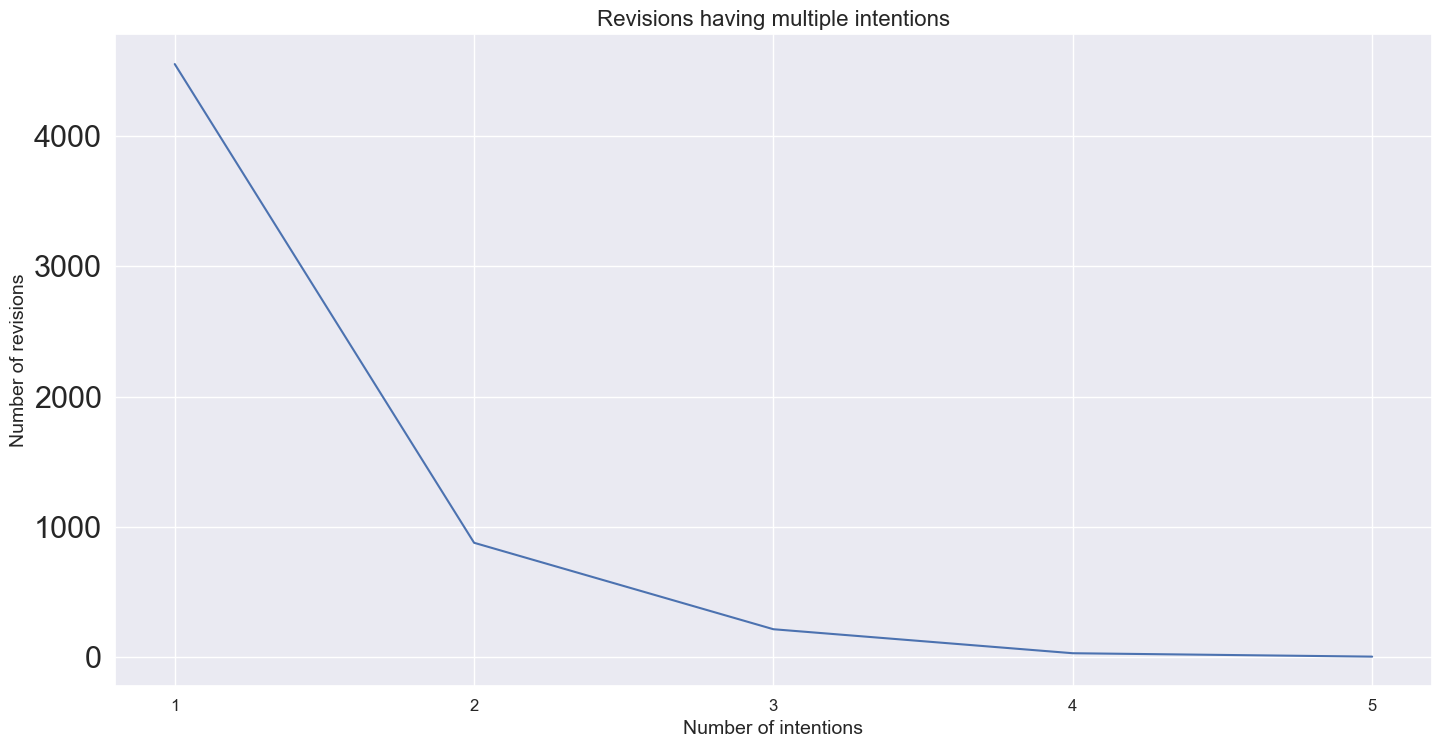

In [27]:
plt.figure(figsize=(15,8))
ax = plt.plot(df['Number of intentions'].values, df['count'].values)
plt.title("Revisions having multiple intentions", fontsize = 16)
plt.ylabel('Number of revisions', fontsize = 14)
plt.xlabel('Number of intentions', fontsize = 14)
plt.xticks(df['Number of intentions'].values, fontsize = 12)
plt.tight_layout()
plt.show()

# Modelo con una intención por predictor

Now we start with the binary classification. In order to start a baseline model Dummy Classifier will be used. This classifier classifies based on the proportion of the labels using simple rules. Precision, Recall and f1 will be used to measure its performance. A cross-validation strategy is used to train and test the algorithms with 4 stratified folds.

The intention 'Other' has been removed for performance reasons as it doesn't have a lot of relevance and its proportion in the dataset makes it hard to be learnt by the classifiers.

In [114]:
#Array with the name of the intentions for future use
intentions = ['counter-vandalism','fact-update','refactoring','copy-editing','wikification',
            'vandalism','simplification','elaboration','verifiability','process','clarification','disambiguation',
            'point-of-view']

sns.reset_orig()

In [118]:
#Setting of a dummy model to create a baseline 
#data to collect : Accuracy, precision, recall, f1_score (micro and macro also)
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix

dummy_precision = []
dummy_recall = []
dummy_f1 = []



from sklearn.metrics import make_scorer

scoring = {'Precision': make_scorer(precision_score), 'recall': make_scorer(recall_score),'f1': make_scorer(f1_score)}

for intention in intentions:
    
    gs_dummy = GridSearchCV(DummyClassifier(random_state=64),
                      param_grid={},
                      scoring=scoring, cv=4, refit='f1', return_train_score=True)
    gs_dummy.fit(X, y[intention])
    results = gs_dummy.cv_results_

    #y_pred = baseline_model.predict(X_test)

    dummy_precision.append(results['mean_test_Precision'][gs_dummy.best_index_])
    dummy_recall.append(results['mean_test_recall'][gs_dummy.best_index_])
    dummy_f1.append(results['mean_test_f1'][gs_dummy.best_index_])



    
dummy_model_data = pandas.DataFrame({'Intention':intentions,'Precision': dummy_precision, 'Recall': dummy_recall
                                     , 'F1': dummy_f1})
dummy_model_data.head(15)


,Intention,Precision,Recall,F1
0,counter-vandalism,0.010864,0.009995,0.010411
1,fact-update,0.034535,0.029457,0.031793
2,refactoring,0.041667,0.039027,0.040303
3,copy-editing,0.185020,0.160165,0.171698
4,wikification,0.413157,0.395302,0.404032
5,vandalism,0.007577,0.007144,0.007354
6,simplification,0.052085,0.046147,0.048936
7,elaboration,0.129831,0.110846,0.119590
8,verifiability,0.147573,0.121075,0.133017
9,process,0.078488,0.066346,0.071908


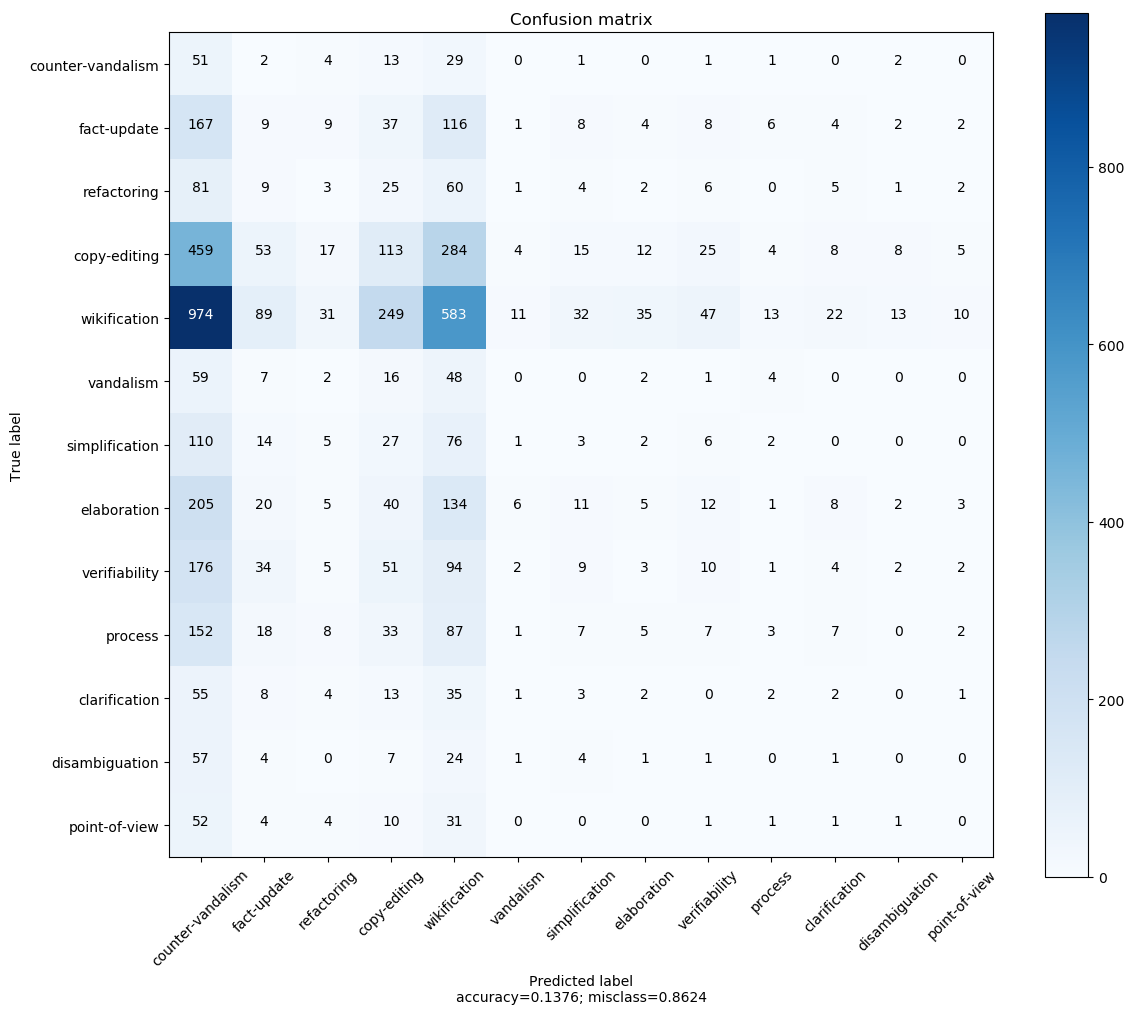

In [119]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MultiLabelBinarizer

pred = pandas.DataFrame()

for intention in intentions:
    clf = DummyClassifier(random_state = 64)
    y_pred = cross_val_predict(clf,X,y[intention],cv=4)
    pred[intention] = y_pred

pred_test = pred
    
y_confusion_matrix = creating_multilabel(y)
mb = MultiLabelBinarizer(classes = intentions)
y_confusion_matrix = mb.fit_transform(y_confusion_matrix)
pred = creating_multilabel(pred)
mb = MultiLabelBinarizer(classes = intentions)
pred = mb.fit_transform(pred)

dummy_micro_scores = pandas.DataFrame({'Precision':precision_score(y_confusion_matrix, pred, average = 'micro'),
                                        'Recall':recall_score(y_confusion_matrix, pred, average = 'micro'),
                                        'F1 micro':f1_score(y_confusion_matrix, pred, average = 'micro')}, index = ['Dummy Classifier'])

cm_BL_dummy = confusion_matrix(y_confusion_matrix.argmax(axis=1), pred.argmax(axis=1))

plot_confusion_matrix(cm_BL_dummy, intentions, normalize = False)

The values of the dummy are generally low, with recall and precision of 0 in some cases. 

In [120]:
base_rf_precision = []
base_rf_recall = []
base_rf_f1 = []



for intention in intentions:
    
    baseline_model = RandomForestClassifier(random_state = 64)
    
    gs_rf = GridSearchCV(baseline_model,
                      param_grid={},
                      scoring=scoring, cv=4, refit='f1', return_train_score=True)
    gs_rf.fit(X, y[intention])
    results = gs_rf.cv_results_


    base_rf_precision.append(results['mean_test_Precision'][gs_rf.best_index_])
    base_rf_recall.append(results['mean_test_recall'][gs_rf.best_index_])
    base_rf_f1.append(results['mean_test_f1'][gs_rf.best_index_])

    

base_rf_model_data = pandas.DataFrame({'Intention':intentions,'Precision':base_rf_precision, 'Recall': base_rf_recall
                                     , 'F1': base_rf_f1
                                   })
base_rf_model_data.head(15)

,Intention,Precision,Recall,F1
0,counter-vandalism,0.870866,0.254259,0.390340
1,fact-update,0.759645,0.257209,0.369556
2,refactoring,0.608652,0.205287,0.301969
3,copy-editing,0.733808,0.394650,0.512596
4,wikification,0.772576,0.624407,0.689090
5,vandalism,0.749375,0.288019,0.412580
6,simplification,0.643821,0.335890,0.398222
7,elaboration,0.736693,0.544813,0.626013
8,verifiability,0.772896,0.639595,0.698970
9,process,0.846705,0.319359,0.463621


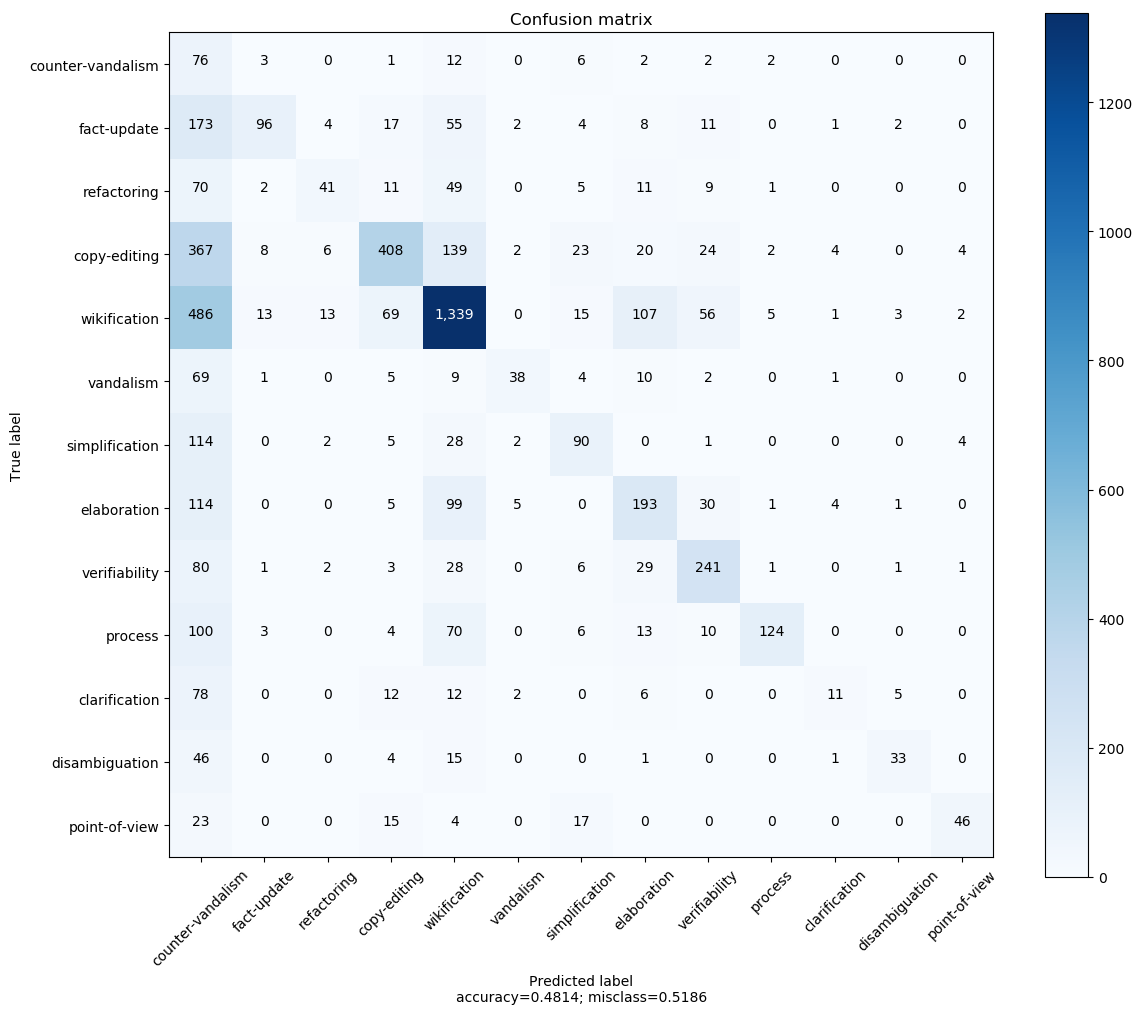

In [121]:
pred = pandas.DataFrame()

for i,intention in zip(range(0,len(intentions)),intentions):
    clf = RandomForestClassifier(random_state = 64)
    y_pred = cross_val_predict(clf,X,y[intention],cv=4)
    pred[intention] = y_pred
    
pred = creating_multilabel(pred)
mb = MultiLabelBinarizer(classes = intentions)
pred = mb.fit_transform(pred)

rf_micro_scores = pandas.DataFrame({'Precision':precision_score(y_confusion_matrix, pred, average = 'micro'),
                                        'Recall':recall_score(y_confusion_matrix, pred, average = 'micro'),
                                        'F1 micro':f1_score(y_confusion_matrix, pred, average = 'micro')},index = ['Random Forest'])

cm_BL_dummy = confusion_matrix(y_confusion_matrix.argmax(axis=1), pred.argmax(axis=1))

plot_confusion_matrix(cm_BL_dummy, intentions, normalize = False)

The values obtained with the Random Forest are clearly better than those of the Dummy. However, recall is still generally low, meaning that due to the imbalance the classifier is classifying more negatives than it should. On the other hand precision values are high across the intentions. Also it can be noted that some intentions appear to be easier to predict than others like wikification (probably due to the fact that its the only balanced intention in the dataset) or verifiability.

In [123]:
base_svc_precision = []
base_svc_recall = []
base_svc_f1 = []


for intention in intentions:
    
    baseline_model = LinearSVC(random_state = 64)
    
    gs_svc = GridSearchCV(baseline_model,
                      param_grid={},
                      scoring=scoring, cv=4, refit='f1', return_train_score=True)
    gs_svc.fit(X_scaled, y[intention])
    results = gs_svc.cv_results_

    base_svc_precision.append(results['mean_test_Precision'][gs_svc.best_index_])
    base_svc_recall.append(results['mean_test_recall'][gs_svc.best_index_])
    base_svc_f1.append(results['mean_test_f1'][gs_svc.best_index_])


base_svc_model_data = pandas.DataFrame({'Intention':intentions,'Precision':base_svc_precision, 'Recall': base_svc_recall
                                     ,'F1': base_svc_f1 })
base_svc_model_data.head(15)

,Intention,Precision,Recall,F1
0,counter-vandalism,0.586231,0.441529,0.495271
1,fact-update,0.527069,0.198248,0.280371
2,refactoring,0.487456,0.258820,0.335521
3,copy-editing,0.582443,0.246944,0.328946
4,wikification,0.740611,0.542971,0.612757
5,vandalism,0.664106,0.286994,0.380450
6,simplification,0.489223,0.178650,0.248467
7,elaboration,0.742780,0.380903,0.501048
8,verifiability,0.731040,0.594170,0.649355
9,process,0.383056,0.081122,0.133490


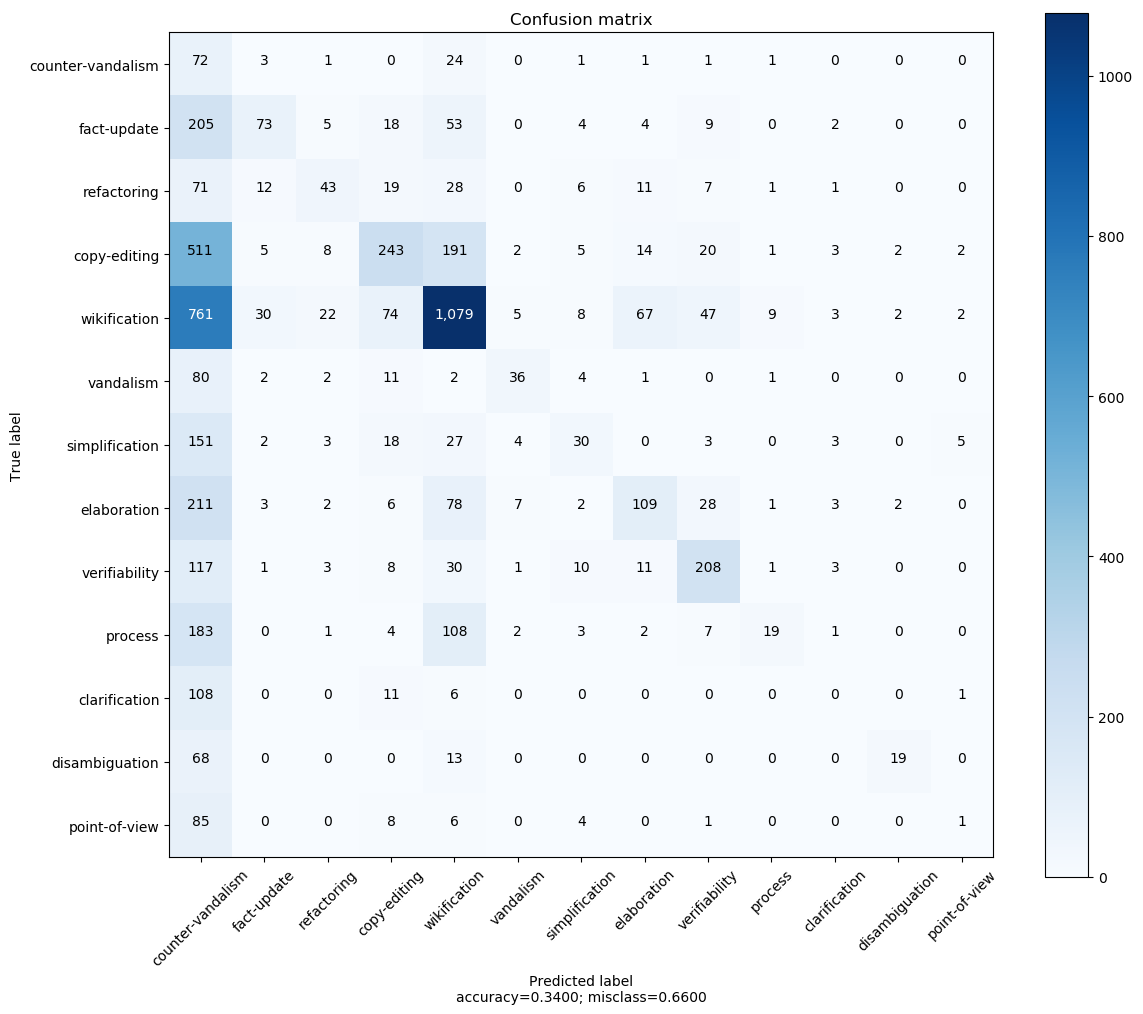

In [124]:
pred = pandas.DataFrame()

for i,intention in zip(range(0,len(intentions)),intentions):
    clf = LinearSVC(random_state = 64)
    y_pred = cross_val_predict(clf,X_scaled,y[intention],cv=4)
    pred[intention] = y_pred
    
pred = creating_multilabel(pred)
mb = MultiLabelBinarizer(classes = intentions)
pred = mb.fit_transform(pred)


svc_micro_scores = pandas.DataFrame({'Precision':precision_score(y_confusion_matrix, pred, average = 'micro'),
                                        'Recall':recall_score(y_confusion_matrix, pred, average = 'micro'),
                                        'F1 micro':f1_score(y_confusion_matrix, pred, average = 'micro')},index = ['SVC'])

cm_BL_dummy = confusion_matrix(y_confusion_matrix.argmax(axis=1), pred.argmax(axis=1))

plot_confusion_matrix(cm_BL_dummy, intentions,  normalize = False)

The SVM has been trained using the scaled data as it is needed in order to obtain a minimum performance with this algorithm. As we can see, we have the same problem as in the forest, the precision is on average way higher than the recall.

In [125]:
print('Dummy classifier micro averaged results')
dummy_micro_scores.head()

Dummy classifier micro averaged results


,Precision,Recall,F1 micro
Dummy Classifier,0.213536,0.191648,0.202001


In [126]:
print('Random Forest classifier micro averaged results')
rf_micro_scores.head()

Random Forest classifier micro averaged results


,Precision,Recall,F1 micro
Random Forest,0.752936,0.477784,0.584602


In [127]:
print('SVC classifier micro averaged results')
svc_micro_scores.head()

SVC classifier micro averaged results


,Precision,Recall,F1 micro
SVC,0.648503,0.371485,0.472376


In this comparison table we can see the three models created up to this point. In all metrics the winner is the random forest. However, before getting into the final tuning of the random forest, more strategies are going to be applied to optimize it even more and see if the SVC still has a chance.

Now we are going to apply over-sampling to the data using the pipeline of imblearn as it only transform the training data during cross-validation, making the process a whole lot easier.

The results are overall better than before and as we can see now, recall values are overall higher than precision values for each intention. The values of F1 remain similar.

In [128]:
base_rf_precision_os = []
base_rf_recall_os = []
base_rf_f1_os = []




for intention in intentions:
    
    baseline_model = RandomForestClassifier(random_state = 64)
    
    model = Pipeline([
        ('sampling', ADASYN()),
        ('classification', baseline_model)
    ])
    
    gs_rf_os = GridSearchCV(model,
                      param_grid={},
                      scoring=scoring, cv=4, refit='f1', return_train_score=True)
    gs_rf_os.fit(X, y[intention])
    results = gs_rf_os.cv_results_


    base_rf_precision_os.append(results['mean_test_Precision'][gs_rf_os.best_index_])
    base_rf_recall_os.append(results['mean_test_recall'][gs_rf_os.best_index_])
    base_rf_f1_os.append(results['mean_test_f1'][gs_rf_os.best_index_])

    

base_rf_model_data_os = pandas.DataFrame({'Intention':intentions,'Precision':base_rf_precision_os, 'Recall': base_rf_recall_os
                                     , 'F1': base_rf_f1_os})
base_rf_model_data_os.head(15)

,Intention,Precision,Recall,F1
0,counter-vandalism,0.776572,0.469645,0.568858
1,fact-update,0.636015,0.452780,0.499347
2,refactoring,0.474831,0.351663,0.394745
3,copy-editing,0.623771,0.554817,0.585943
4,wikification,0.754200,0.673924,0.710337
5,vandalism,0.619588,0.474176,0.517402
6,simplification,0.539104,0.459554,0.397704
7,elaboration,0.626878,0.670985,0.648064
8,verifiability,0.733510,0.725040,0.729064
9,process,0.623824,0.439884,0.510884


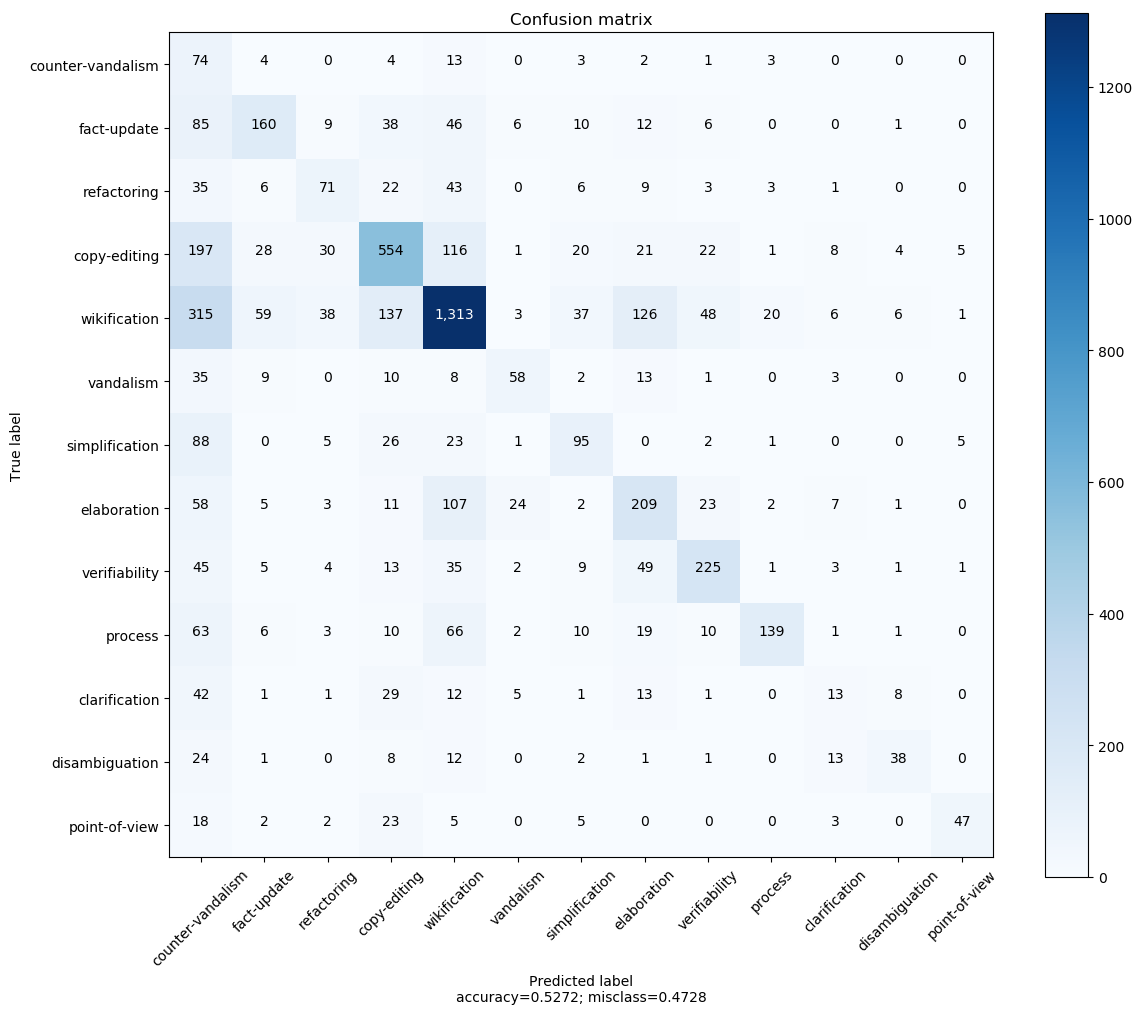

In [129]:
pred = pandas.DataFrame()

for i,intention in zip(range(0,len(intentions)),intentions):
    clf = Pipeline([
                ('sampling', ADASYN()),
                ('classification', RandomForestClassifier(random_state = 64))
                ])
    y_pred = cross_val_predict(clf,X,y[intention],cv=4)
    pred[intention] = y_pred
    
pred = creating_multilabel(pred)
mb = MultiLabelBinarizer(classes = intentions)
pred = mb.fit_transform(pred)


rf_os_micro_scores = pandas.DataFrame({'Precision':precision_score(y_confusion_matrix, pred, average = 'micro'),
                                        'Recall':recall_score(y_confusion_matrix, pred, average = 'micro'),
                                        'F1 micro':f1_score(y_confusion_matrix, pred, average = 'micro')},index = ['Random Forest with OS'])

cm_BL_dummy = confusion_matrix(y_confusion_matrix.argmax(axis=1), pred.argmax(axis=1))

plot_confusion_matrix(cm_BL_dummy, intentions, normalize = False)

We can see that unlike with the SVC the recall values are still lower than the precision ones. Nevertheless, we have obtained hig,her results overal through the use of oversampling.

In [130]:
print("Random forest after Over-Sampling micro averaged results")
rf_os_micro_scores.head()

Random forest after Over-Sampling micro averaged results


,Precision,Recall,F1 micro
Random Forest with OS,0.660256,0.579303,0.617136


In [131]:
print('Random Forest classifier micro averaged results')
rf_micro_scores.head()

Random Forest classifier micro averaged results


,Precision,Recall,F1 micro
Random Forest,0.752936,0.477784,0.584602


The metrics of this table has been calculated doing an average of each intention model's scores without taking into account the different representation of each intention.

In this comparison table is easy to see that oversampling has had an effect in the classifiers results. 
In the SVC we see a shift in recall and precision values with a reduction of f1 micro and a similar value of f1 macro. 
In the random forest the precision has been affected and its lower however its recall has increased a lot, even though the ideal sitaution would be an increase in both, a more balanced precision/recall tradeoff is also acceptable. F1 scores remain quite similar, with a slight increase of the macro averaged one.

Overall, teh chosen model to continue is the random forest due to its better scores.

Now, we are going to proceed with feature engineering in the random forest to see if we can obtain better values before the tuning of its parameters.

In [135]:
scores_all = []
scores_selected = []

fe_rf_precision = []
fe_rf_recall = []
fe_rf_f1 = []
fe_rf_thresholds = []

fe_rf_models = []


for intention in intentions:

    baseline_model = RandomForestClassifier(random_state = 64)
    
    model = Pipeline([
        ('sampling', ADASYN()),
        ('features', SelectFromModel(
                    RandomForestClassifier(random_state = 64))),
        ('classification', baseline_model)
    ])
    
    gs_rf_fe = GridSearchCV(model,
                      param_grid={'features__threshold': ['0.75*mean','mean','1.25*mean','1.5*mean','0*mean']},
                      scoring=scoring, cv=4, refit='f1', return_train_score=True)
    gs_rf_fe.fit(X, y[intention])
    results = gs_rf_fe.cv_results_
    fe_rf_models.append(gs_rf_fe)

    fe_rf_precision.append(results['mean_test_Precision'][gs_rf_fe.best_index_])
    fe_rf_recall.append(results['mean_test_recall'][gs_rf_fe.best_index_])
    fe_rf_f1.append(results['mean_test_f1'][gs_rf_fe.best_index_])
    fe_rf_thresholds.append(gs_rf_fe.best_params_['features__threshold'])
   
    

fe_rf_model_data = pandas.DataFrame({'Intention':intentions,'Precision':fe_rf_precision, 'Recall': fe_rf_recall
                                     , 'F1': fe_rf_f1, 'Feature Engineering Threshold': fe_rf_thresholds})
fe_rf_model_data.head(15)

,Intention,Precision,Recall,F1,Feature Engineering Threshold
0,counter-vandalism,0.778699,0.646185,0.689049,mean
1,fact-update,0.514346,0.487699,0.493058,1.25*mean
2,refactoring,0.468619,0.351677,0.398886,0*mean
3,copy-editing,0.641270,0.563405,0.598175,0*mean
4,wikification,0.759129,0.663853,0.707014,0*mean
5,vandalism,0.645099,0.496018,0.542738,0*mean
6,simplification,0.485749,0.422459,0.398862,0*mean
7,elaboration,0.651809,0.670993,0.660862,0*mean
8,verifiability,0.726087,0.737927,0.728638,0.75*mean
9,process,0.573872,0.474249,0.517251,mean


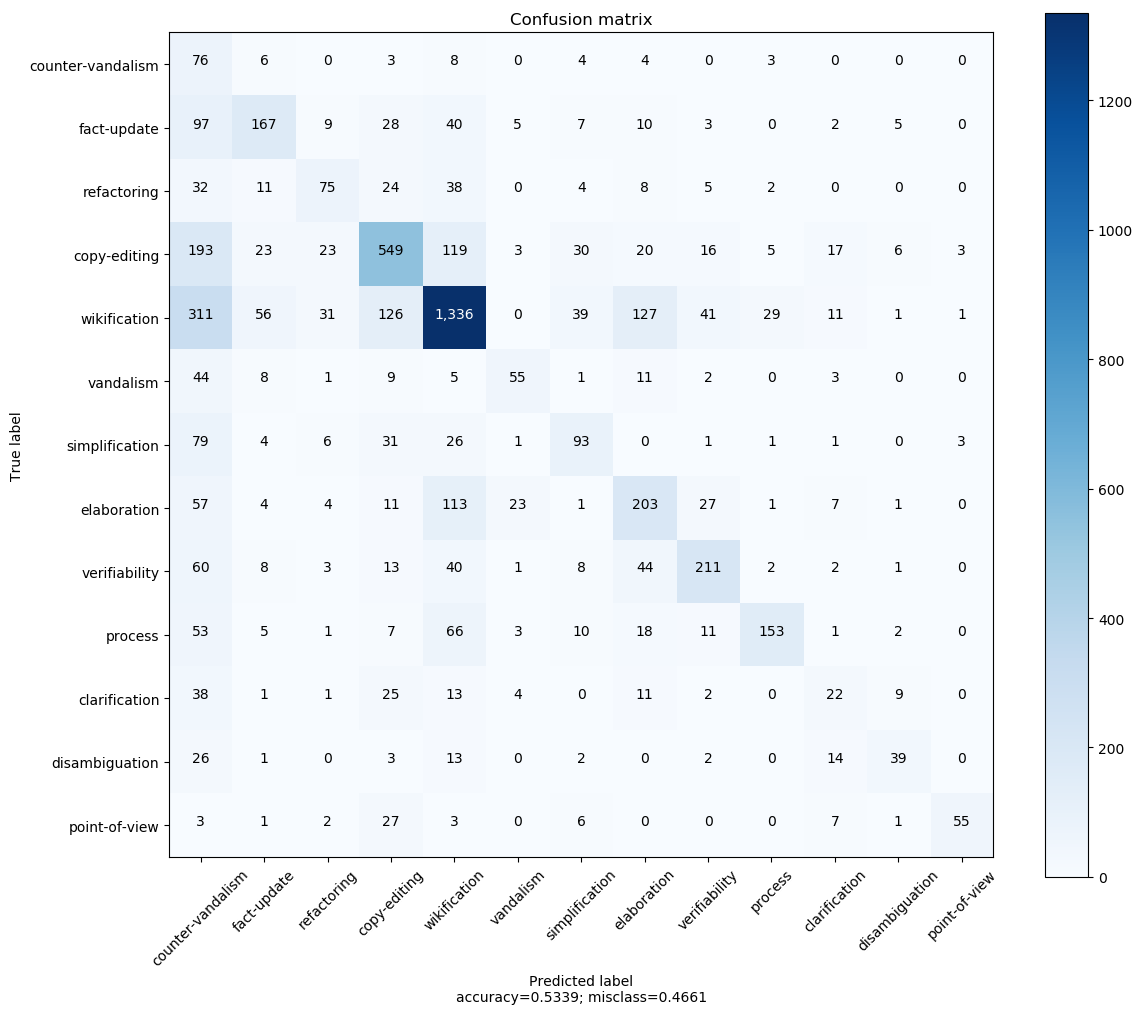

In [136]:
pred = pandas.DataFrame()

for i,intention in zip(range(0,len(intentions)),intentions):
    clf = Pipeline([
                ('sampling', ADASYN()),
                ('features', SelectFromModel(RandomForestClassifier(random_state = 64), threshold = fe_rf_models[i].best_params_['features__threshold'])),
                ('classification', RandomForestClassifier(random_state = 64))
                ])
    y_pred = cross_val_predict(clf,X,y[intention],cv=4)
    pred[intention] = y_pred
    
pred = creating_multilabel(pred)
mb = MultiLabelBinarizer(classes = intentions)
pred = mb.fit_transform(pred)


rf_fe_micro_scores = pandas.DataFrame({'Precision':precision_score(y_confusion_matrix, pred, average = 'micro'),
                                        'Recall':recall_score(y_confusion_matrix, pred, average = 'micro'),
                                        'F1 micro':f1_score(y_confusion_matrix, pred, average = 'micro')},index = ['Random Forest with OS and FE'])

cm_BL_dummy = confusion_matrix(y_confusion_matrix.argmax(axis=1), pred.argmax(axis=1))

plot_confusion_matrix(cm_BL_dummy, intentions, normalize = False)

Using the pipeline of imblearn we applied Model based feature engineering with 4 different thresholds through grid search. This way each models applies the feature engineering that fits the most. The thresholds are 0.75*mean, mean, 1.25*mean and 1.5*mean. 

In general, recall and precision values are higher, f1 values are also higher. Its interesting to notice that the improvements in some intentions are huge like in the case of point of view which is almost perfectly predicted.

In [137]:
print("Random Forest with Over-Sampling and Feature engineering micro averaged results")
rf_fe_micro_scores.head()

Random Forest with Over-Sampling and Feature engineering micro averaged results


,Precision,Recall,F1 micro
Random Forest with OS and FE,0.659094,0.599691,0.627991


*Again the metrics of this table have been calculated through normal average, without considering the different proportions.

Clearly the feature engineering has given a boost of performance in f1 macro and recall. However f1 micro and precision have decreased slightly. In any case the difference is so low is almost unnoticeable.

Now we proceed with the tuning of the random forest with oversampling and feature engineering. The range of parameters for the number of estimators goes from 1 to 512.

In [138]:
from sklearn.model_selection import GridSearchCV
from imblearn.pipeline import Pipeline 

#Random Forest Optimization
#Parameters to optimize in the random forest, the amount of estimators, which means number of trees in the forest
parameters= {'classification__n_estimators' : [1,2,4,8,16,32,48,64,80,96,128,160,192,256,385,512],
            'features__threshold': ['0.75*mean','mean','1.25*mean','1.5*mean','0*mean']}

tuning_rf_precision = []
tuning_rf_recall = []
tuning_rf_f1 = []
tuning_rf_threshold = []
tuning_rf_estimators = []


cv_results_rf_tuning = []

tuned_models = []

#Loop for each intention
for intention in intentions:
    
    baseline_model = RandomForestClassifier(random_state = 64)
    
    model = Pipeline([
        ('sampling', ADASYN()),
        ('features', SelectFromModel(
                    RandomForestClassifier(random_state = 64))),
        ('classification', baseline_model)
    ])
    
    gs_rf_tuned = GridSearchCV(model,
                       parameters,
                      scoring=scoring, cv=4, refit='f1', return_train_score=True)
    gs_rf_tuned.fit(X, y[intention])
    results = gs_rf_tuned.cv_results_
    cv_results_rf_tuning.append(results)
    tuned_models.append(gs_rf_tuned)

    tuning_rf_precision.append(results['mean_test_Precision'][gs_rf_tuned.best_index_])
    tuning_rf_recall.append(results['mean_test_recall'][gs_rf_tuned.best_index_])
    tuning_rf_f1.append(results['mean_test_f1'][gs_rf_tuned.best_index_])
    tuning_rf_threshold.append( gs_rf_tuned.best_params_['features__threshold'])
    tuning_rf_estimators.append(gs_rf_tuned.best_params_['classification__n_estimators'])



tuning_rf_model_data = pandas.DataFrame({'Intention':intentions,'Precision':tuning_rf_precision, 'Recall': tuning_rf_recall
                                     , 'F1': tuning_rf_f1
                                     ,'FE threshold': tuning_rf_threshold,'N_estimators': tuning_rf_estimators})
tuning_rf_model_data.head(15)

,Intention,Precision,Recall,F1,FE threshold,N_estimators
0,counter-vandalism,0.783431,0.676176,0.706612,1.5*mean,64
1,fact-update,0.558906,0.543944,0.543074,1.25*mean,80
2,refactoring,0.546315,0.434896,0.474446,0*mean,192
3,copy-editing,0.666840,0.624414,0.643379,0*mean,160
4,wikification,0.765452,0.749881,0.756498,0*mean,385
5,vandalism,0.601898,0.596036,0.567303,mean,385
6,simplification,0.622854,0.484270,0.429509,0*mean,160
7,elaboration,0.664187,0.739382,0.699402,0*mean,256
8,verifiability,0.733537,0.777813,0.753520,0.75*mean,192
9,process,0.630852,0.513652,0.564177,mean,64


Impressively enough, point of view scores are all of 1 meaning that it is been predicted perfectly. Some intentions have way better scores than others however the improvements compared with the default random forest are easily noticed.

In [139]:
for dataframe,intention in zip(cv_results_rf_tuning,intentions):
    print(intention + ' Cross Validation results using f1')
    display(dataframe)

counter-vandalism Cross Validation results using f1


{'mean_fit_time': array([ 0.3114171 ,  0.31191546,  0.3091802 ,  0.30393714,  0.31466484,
         0.31391066,  0.30768448,  0.30692887,  0.30817592,  0.33162773,
         0.34110385,  0.34235758,  0.32414955,  0.31566352,  0.38074809,
         0.39596331,  0.38998073,  0.39796644,  0.3941955 ,  0.4645074 ,
         0.50193405,  0.49420655,  0.4657864 ,  0.47300869,  0.58218449,
         0.75750452,  0.73207319,  0.69329238,  0.66573316,  0.8784005 ,
         0.93425059,  0.89311063,  0.84598666,  0.86245888,  1.18735504,
         1.14945567,  1.12103313,  1.06293786,  0.97991186,  1.47832948,
         1.37058455,  1.31348735,  1.22871482,  1.12174988,  1.78348786,
         1.56210202,  1.51247102,  1.43485188,  1.31697851,  2.06572533,
         2.06823283,  1.90767694,  1.89545703,  1.70098495,  2.63813168,
         2.53422201,  2.36367846,  2.11014807,  2.11337715,  3.27401912,
         3.02690393,  2.60005295,  2.46244597,  2.49186707,  3.82424843,
         3.97212583,  3.56797832, 

fact-update Cross Validation results using f1


{'mean_fit_time': array([ 0.39247322,  0.37228596,  0.37949955,  0.36828768,  0.3942222 ,
         0.38998014,  0.37602031,  0.3919732 ,  0.38973659,  0.41464847,
         0.41765672,  0.40868545,  0.41018409,  0.38749194,  0.46799779,
         0.50689381,  0.46799791,  0.45353645,  0.45428431,  0.57770419,
         0.63134098,  0.57448697,  0.5409326 ,  0.54656011,  0.74377471,
         0.89064336,  0.80762076,  0.74204409,  0.71262717,  1.14695591,
         1.17538393,  1.03500986,  0.93726957,  0.89962327,  1.5159781 ,
         1.38756996,  1.28969455,  1.14320076,  1.09708291,  1.90443707,
         1.59576201,  1.51248783,  1.30628681,  1.26988465,  2.23479545,
         2.09116346,  1.65307873,  1.53141326,  1.54440278,  2.67138708,
         2.51478934,  2.1921674 ,  1.9752236 ,  1.73586494,  3.39370531,
         3.12242848,  2.66237789,  2.27388191,  2.09216279,  4.22969615,
         3.69189084,  3.14434671,  2.78082031,  2.45980871,  5.188622  ,
         4.722377  ,  4.18904573, 

refactoring Cross Validation results using f1


{'mean_fit_time': array([ 0.44431186,  0.44658399,  0.42215222,  0.41093224,  0.44358802,
         0.45556062,  0.44957054,  0.44407994,  0.4266389 ,  0.48270893,
         0.49246418,  0.48498219,  0.4765023 ,  0.46353328,  0.55154061,
         0.55278045,  0.55603874,  0.53360522,  0.52986383,  0.67497879,
         0.70213765,  0.6790815 ,  0.69590545,  0.70264328,  0.99211377,
         1.05528092,  1.02234316,  1.05194366,  0.86470169,  1.58952165,
         1.52727193,  1.25920844,  1.19421577,  1.09017015,  2.02154499,
         1.68480682,  1.36605662,  1.38368219,  1.27197683,  2.46619487,
         1.9380582 ,  1.63626802,  1.564125  ,  1.43049693,  3.04138929,
         2.31722468,  1.9759953 ,  1.93061924,  1.78686309,  3.58209777,
         2.63510942,  2.35545468,  2.24694592,  2.1093877 ,  4.53893405,
         3.38233703,  2.97347444,  2.65615737,  2.4923256 ,  5.66152269,
         4.12113553,  3.69080156,  3.31033623,  2.91101491,  6.73751438,
         5.18103158,  4.19770896, 

copy-editing Cross Validation results using f1


{'mean_fit_time': array([ 0.71904552,  0.71655506,  0.66697973,  0.7365222 ,  0.69736117,
         0.70641732,  0.73019493,  0.69732028,  0.68666369,  0.71375406,
         0.7934956 ,  0.77441025,  0.74010843,  0.7245484 ,  0.82587355,
         0.85417402,  0.82250911,  0.8093912 ,  0.78345996,  0.98251307,
         1.10725725,  0.82638353,  0.78555578,  0.73524743,  0.83498681,
         1.21634316,  1.13049728,  1.07472777,  0.97649884,  1.15686476,
         1.48182636,  1.44862729,  1.32996178,  1.27487034,  1.50596303,
         1.90319258,  1.7514782 ,  1.59772068,  1.62304962,  2.35880506,
         2.75255316,  2.58396572,  2.41307926,  2.33624762,  3.01999277,
         3.38109618,  3.11529458,  2.93585497,  2.66403407,  3.51224887,
         4.20745999,  3.88687354,  3.75519162,  3.28703028,  4.4501906 ,
         5.04212189,  4.83960176,  4.37500298,  3.96244544,  5.2440877 ,
         5.9857524 ,  5.52743548,  5.19075286,  4.16754162,  5.54770875,
         7.72502691,  7.45561182, 

wikification Cross Validation results using f1


{'mean_fit_time': array([0.36577904, 0.39818507, 0.34258348, 0.3540529 , 0.38521981,
        0.40416873, 0.38172913, 0.41987687, 0.38597518, 0.37050837,
        0.38247716, 0.38497603, 0.41513932, 0.44631463, 0.50553554,
        0.57402438, 0.48470843, 0.48175561, 0.46233737, 0.47528034,
        0.56374365, 0.54711473, 0.52816033, 0.49120969, 0.52661258,
        0.6876843 , 0.67146945, 0.65002638, 0.61587715, 0.6923992 ,
        0.84675831, 0.80612361, 0.7784391 , 0.76472563, 0.847242  ,
        1.03823912, 1.00483519, 0.94473112, 0.88915485, 0.97839761,
        1.16565728, 1.15194035, 1.08787113, 1.06268197, 1.13449645,
        1.32970172, 1.29229409, 1.22749949, 1.14394891, 1.28983337,
        1.64487237, 1.62168574, 1.53814989, 1.43875372, 1.61892074,
        1.96723956, 1.93659508, 1.94961333, 1.80070823, 1.95753878,
        2.30384511, 2.24176967, 2.17794746, 2.02460945, 2.25026208,
        2.94900966, 2.86311704, 2.81970799, 2.60779059, 2.91546804,
        4.28703481, 4.10309571,

vandalism Cross Validation results using f1


{'mean_fit_time': array([ 0.38980883,  0.37006921,  0.36297858,  0.37163252,  0.39221615,
         0.38919187,  0.38991046,  0.3798089 ,  0.38155144,  0.42501622,
         0.41003984,  0.41398388,  0.40874475,  0.39747471,  0.46656245,
         0.49985391,  0.47959459,  0.44558883,  0.47419947,  0.539612  ,
         0.57616991,  0.5846594 ,  0.54762346,  0.51939899,  0.72753513,
         0.85912347,  0.79995316,  0.81486005,  0.72737068,  1.09144229,
         1.07788855,  1.01877135,  0.97743839,  0.88789159,  1.46255863,
         1.29780579,  1.22899473,  1.15249586,  1.09556717,  1.80764246,
         1.51522344,  1.4357298 ,  1.39768898,  1.34911197,  2.19426924,
         1.85124981,  1.55444002,  1.54290998,  1.51915723,  2.5021202 ,
         2.13899404,  2.162341  ,  1.83206463,  1.64937484,  3.3993336 ,
         2.60750061,  2.71102351,  2.37105858,  2.2854656 ,  3.99987572,
         3.38538104,  2.77635819,  2.89322561,  2.62289202,  4.77921814,
         3.89453351,  3.81831843, 

simplification Cross Validation results using f1


{'mean_fit_time': array([ 0.51054978,  0.49056083,  0.52513903,  0.51155895,  0.5295397 ,
         0.53168428,  0.53680331,  0.50163323,  0.60931146,  0.58683205,
         0.5840475 ,  0.55930221,  0.54280752,  0.55065525,  0.63754708,
         0.68694514,  0.67971998,  0.59031701,  0.65995198,  0.7565611 ,
         1.09994429,  1.11006653,  0.99308527,  1.00621825,  1.43961102,
         1.64840561,  1.4736433 ,  1.39607078,  1.41155094,  2.18716192,
         1.82209283,  1.85427594,  1.82189411,  1.6940282 ,  2.53717649,
         2.52414894,  2.1437248 ,  1.58994627,  1.88075089,  3.06597471,
         2.33345264,  2.12480164,  1.76015425,  1.89316964,  3.28996497,
         2.70976233,  2.41240382,  2.00175971,  1.92438531,  3.76238543,
         3.32265389,  2.7394644 ,  2.80405045,  2.56950325,  4.72557491,
         3.88343263,  3.45118541,  2.84059006,  2.77683938,  5.01012486,
         4.2464003 ,  3.76656961,  3.13738042,  3.22813982,  6.04515797,
         5.69192314,  4.85653549, 

elaboration Cross Validation results using f1


{'mean_fit_time': array([ 0.39545834,  0.39795148,  0.41066539,  0.39121938,  0.43261194,
         0.42862678,  0.42214417,  0.40667087,  0.40046024,  0.42611825,
         0.45428485,  0.47349977,  0.43037009,  0.42887604,  0.46852911,
         0.5308544 ,  0.48745859,  0.46952856,  0.47126549,  0.57647431,
         0.66747367,  0.61414069,  0.59789962,  0.58795226,  0.74503314,
         0.98436689,  0.88763392,  0.81631762,  0.79490721,  1.09980893,
         1.27509016,  1.12948018,  0.99685854,  1.02678519,  1.45735347,
         1.55060309,  1.38803846,  1.2127651 ,  1.19780314,  1.82013255,
         1.87024868,  1.75555432,  1.57827854,  1.41098481,  2.16046458,
         2.23377669,  1.92210895,  1.66903627,  1.50846624,  2.54719496,
         2.75587893,  2.45018864,  2.12456745,  1.93682659,  3.23085213,
         3.39094579,  2.7542541 ,  2.78253758,  2.26394463,  3.99507248,
         3.89756787,  3.42060792,  3.16378832,  2.836164  ,  4.66252995,
         5.23508602,  4.13770705, 

verifiability Cross Validation results using f1


{'mean_fit_time': array([ 0.39994663,  0.38922352,  0.38947344,  0.39271885,  0.41116649,
         0.40642357,  0.40617239,  0.39596629,  0.41890693,  0.43312418,
         0.43337148,  0.43484509,  0.41689956,  0.44657207,  0.49369627,
         0.49419349,  0.46104872,  0.53656936,  0.46328264,  0.58867621,
         0.60041553,  0.55204773,  0.53534311,  0.52861893,  0.81083131,
         0.82805181,  0.71908444,  0.71012378,  0.7702173 ,  1.32024342,
         1.02951258,  0.98886353,  0.83402771,  0.83002728,  1.61781549,
         1.29428166,  1.0589335 ,  1.01080447,  1.00356632,  2.10537696,
         1.52642447,  1.26862776,  1.15342581,  1.16065472,  2.60977066,
         1.71891028,  1.38106406,  1.22125012,  1.30849987,  2.86560071,
         2.2873829 ,  1.78473496,  1.6964615 ,  1.6585803 ,  3.67566842,
         2.52774715,  2.1172365 ,  1.89766836,  1.82462782,  4.59845954,
         2.92563623,  2.65564698,  2.13281131,  2.18142384,  5.24997216,
         3.7439875 ,  2.99123031, 

process Cross Validation results using f1


{'mean_fit_time': array([ 0.41408211,  0.43439656,  0.48338145,  0.45412356,  0.53581798,
         0.48793769,  0.53628516,  0.48073751,  0.4948045 ,  0.42139828,
         0.46359551,  0.42694002,  0.42281312,  0.487037  ,  0.66151911,
         0.56839269,  0.53478163,  0.48339766,  0.48076999,  0.54118133,
         0.69399273,  0.64867342,  0.62299156,  0.59644252,  0.71848506,
         0.98063463,  0.9154743 ,  0.85727262,  0.79595661,  1.04128993,
         1.32103491,  1.1813013 ,  1.0711512 ,  1.03768736,  1.4117232 ,
         1.63499069,  1.56051534,  1.35830849,  1.34464657,  1.7556513 ,
         1.98424488,  1.78066421,  1.59898883,  1.49413764,  2.09537858,
         2.27103829,  2.17238772,  1.98416269,  1.80876356,  2.41270506,
         2.96207178,  2.62470466,  2.27075207,  2.23539698,  3.17059392,
         3.47743523,  3.10478187,  2.95761436,  2.77614737,  4.00206363,
         4.28088272,  3.62288946,  3.42949176,  3.57637733,  5.32130915,
         6.06923002,  5.52575272, 

clarification Cross Validation results using f1


{'mean_fit_time': array([ 0.44607943,  0.41466588,  0.40018767,  0.40767348,  0.42563611,
         0.43411916,  0.43112725,  0.41367394,  0.44010156,  0.44730341,
         0.48322994,  0.46777028,  0.48601902,  0.47149712,  0.51237959,
         0.5852018 ,  0.56699151,  0.54706717,  0.51913488,  0.59939665,
         0.8068499 ,  0.73555768,  0.70450807,  0.70612651,  0.81631744,
         1.1738826 ,  1.05021971,  1.01929605,  0.9620927 ,  1.23370081,
         1.56931758,  1.37733626,  1.27734125,  1.20306128,  1.68775815,
         1.97873825,  1.79896957,  1.69749051,  1.57107747,  2.18883914,
         2.35644811,  2.07483542,  1.99067593,  1.81840575,  2.60207206,
         2.70760339,  2.49407929,  2.25023925,  1.89994919,  3.06282288,
         3.55750066,  3.149638  ,  2.75788957,  2.61094618,  3.98110956,
         4.39438051,  3.82377392,  3.54653674,  3.07004553,  4.84979481,
         5.23377568,  4.65514326,  4.22870547,  3.94520605,  5.74260503,
         6.73873436,  6.09732741, 

disambiguation Cross Validation results using f1


{'mean_fit_time': array([ 0.36106634,  0.34957236,  0.35082906,  0.34211272,  0.37800348,
         0.37426078,  0.40267283,  0.36352903,  0.34409457,  0.38771373,
         0.39544314,  0.42087376,  0.39370412,  0.38596886,  0.4303633 ,
         0.47747403,  0.47200692,  0.45429027,  0.44007277,  0.52459627,
         0.65125674,  0.58918995,  0.60814309,  0.5435642 ,  0.6727007 ,
         0.95794541,  0.86894089,  0.84805924,  0.8185854 ,  1.04221439,
         1.25663912,  1.13596946,  1.19031525,  1.02127272,  1.49225956,
         1.671529  ,  1.49451208,  1.37882042,  1.33791447,  1.88795024,
         2.0604884 ,  1.8037008 ,  1.49800932,  1.53889197,  2.08748704,
         2.21058708,  1.91412991,  1.79772353,  1.63038999,  2.41007018,
         2.86685485,  2.45570469,  2.27862602,  1.92510813,  3.10347426,
         3.3460651 ,  3.15432882,  2.97155964,  2.41581082,  3.74474943,
         3.91877592,  3.75593561,  3.27800733,  3.01321393,  4.46902865,
         5.17566037,  4.89167571, 

point-of-view Cross Validation results using f1


{'mean_fit_time': array([0.29022467, 0.29246783, 0.34358102, 0.28349322, 0.31641018,
        0.29371458, 0.31216544, 0.35654759, 0.28998178, 0.32887173,
        0.31890368, 0.31166553, 0.33161533, 0.30120522, 0.39097214,
        0.34458232, 0.32963234, 0.34732908, 0.3415947 , 0.46799982,
        0.44730377, 0.44107121, 0.42362416, 0.41964322, 0.58718026,
        0.5784511 , 0.53781134, 0.55202323, 0.52959353, 0.92627329,
        0.66823614, 0.61214638, 0.5789535 , 0.5507856 , 1.1436919 ,
        0.77692294, 0.80585212, 0.69789219, 0.67793721, 1.47605407,
        0.94049287, 0.90906078, 0.90358359, 0.79238141, 1.79918158,
        1.11639398, 0.9614464 , 0.80535668, 0.7824313 , 2.02794993,
        1.1581521 , 1.22971034, 1.08086681, 1.00308323, 2.53671736,
        1.38711435, 1.40998894, 1.27510518, 1.18110824, 3.04111576,
        1.93209904, 1.49201685, 1.58900714, 1.37856942, 3.74797517,
        2.34024155, 2.03904647, 1.79046816, 1.74608684, 4.69244874,
        3.09672648, 2.83416301,

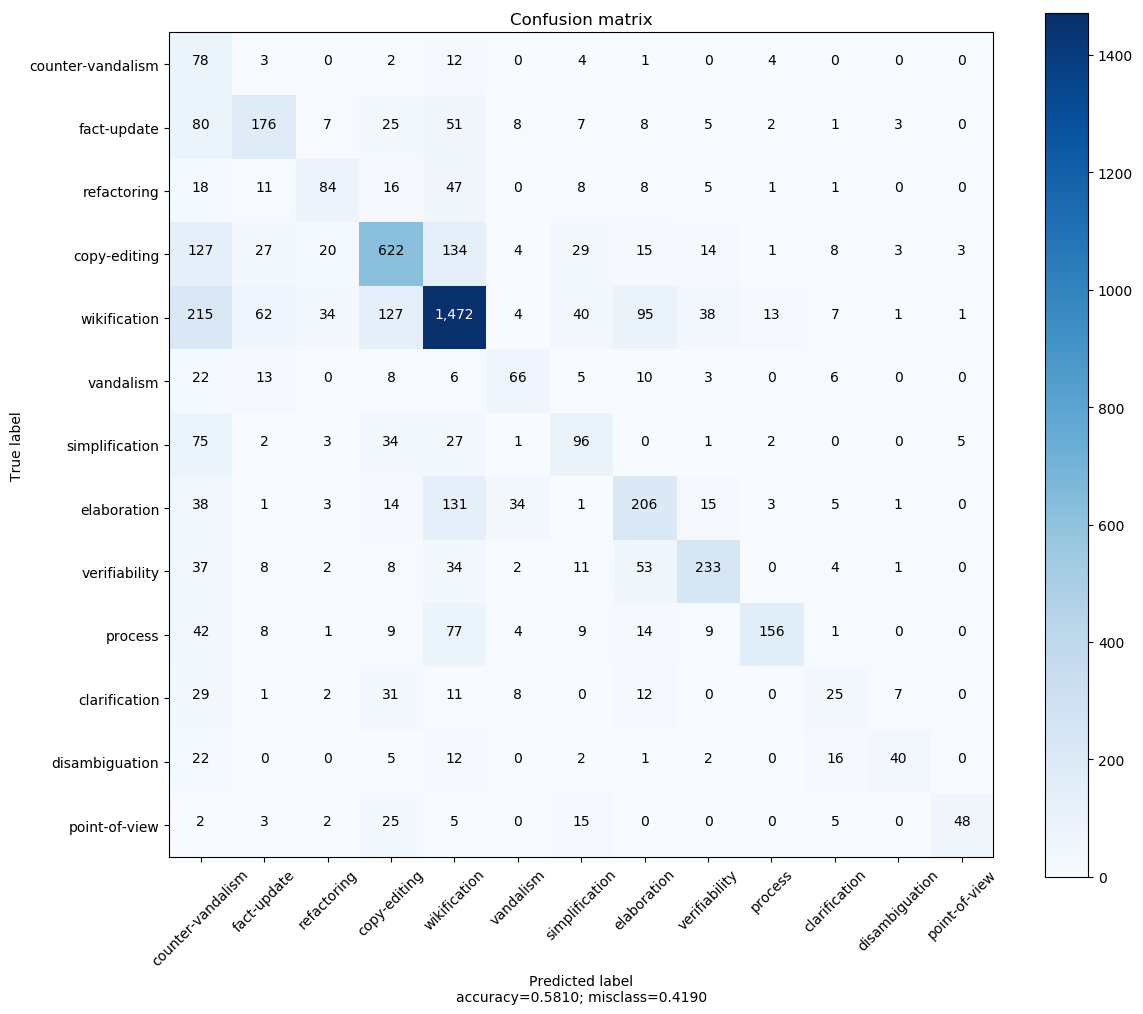

In [141]:
pred = pandas.DataFrame()

for i,intention in zip(range(0,len(intentions)),intentions):
    clf = Pipeline([
                ('sampling', ADASYN()),
                ('features', SelectFromModel(RandomForestClassifier(random_state = 64), threshold = tuned_models[i].best_params_['features__threshold'])),
                ('classification', RandomForestClassifier(random_state = 64, n_estimators = tuned_models[i].best_params_['classification__n_estimators']))
                ])
    y_pred = cross_val_predict(clf,X,y[intention],cv=4)
    pred[intention] = y_pred
    
pred = creating_multilabel(pred)
mb = MultiLabelBinarizer(classes = intentions)
pred = mb.fit_transform(pred)


rf_tuned_micro_scores = pandas.DataFrame({'Precision':precision_score(y_confusion_matrix, pred, average = 'micro'),
                                        'Recall':recall_score(y_confusion_matrix, pred, average = 'micro'),
                                        'F1 micro':f1_score(y_confusion_matrix, pred, average = 'micro')},index = ['Tuned Random Forest'])

cm_BL_dummy = confusion_matrix(y_confusion_matrix.argmax(axis=1), pred.argmax(axis=1))

plot_confusion_matrix(cm_BL_dummy, intentions, normalize = False)

In [142]:
print("Tuned Random Forest micro averaged results")
rf_tuned_micro_scores.head()

Tuned Random Forest micro averaged results


,Precision,Recall,F1 micro
Tuned Random Forest,0.664883,0.663948,0.664415


Clearly the tuning has improved the results even further, obtaining precision and recall over .6 on average and a f1 macro of 0.78. In general, while not brilliant, we could consider this results a success.

This piece of code exports the models into a folder for future uses

In [26]:
from sklearn.externals import joblib
import os
import shutil
#Remove the already existing trained model (if existing) and create a new folder for the new models
#This way we also guarantee that there wont be redundant models. 
#If you want to keep older models, change them to another folder.
shutil.rmtree('trained_models', ignore_errors=True)
os.mkdir('trained_models')
#Then we just assign the name of the intention and export with joblib extension.
model_index = 0
for intention in intentions:
    joblib.dump(models[model_index], 'trained_models/'+intention+'_classificator.plk')
    model_index += 1

print("Models exported succesfully")

Models exported succesfully


# Clasificación multi-label

Now its time to perform the multilabel classification approach. The multilabel classification allows to have one or more labels for each revision, only requiring to make one model to predict all the intentions. 

Ir oder to give the promer formatting to the data for this approach a function called creatingMultilabel has been created, it basically mix all the intentions in only one column. Then multilabelBinarizer is used to give it the sparse matrix format as it is required by the classification algorithms.

In [150]:
#Array with the name of the intentions for future use
intentions = ['counter-vandalism','fact-update','refactoring','copy-editing','other','wikification',
            'vandalism','simplification','elaboration','verifiability','process','clarification','disambiguation',
            'point-of-view']

In [151]:
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import f1_score
from skmultilearn.adapt import MLkNN
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from evolutionary_search import EvolutionaryAlgorithmSearchCV
from sklearn.preprocessing import StandardScaler  

import pandas
import numpy as np
import seaborn as sns
import warnings; warnings.simplefilter('ignore')
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from imblearn.over_sampling import ADASYN
from sklearn.datasets import make_classification
from sklearn.metrics import roc_curve, auc
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn import svm

dataset = pandas.read_csv('data/edit_intention_dataset_featured.csv', sep=',')
X, y = dataset.iloc[:, :-14], dataset.iloc[:, -14:]
kwargs = dict(test_size=0.2, random_state=1)
y = creating_multilabel(y)
mb = MultiLabelBinarizer(classes = intentions)
y = mb.fit_transform(y)
feature_scaler = StandardScaler()  
X_scaled = feature_scaler.fit_transform(X)  
#X_train, X_test, y_train, y_test = train_test_split(X, y, **kwargs)
#Figures size
plt.rcParams['savefig.dpi'] = 100

sns.reset_orig()


Now the data is ready to be used. A cross-validation strategy is used to train and test the algorithms with 4 stratified folds.

Again we create a dummy classifier to create a baseline.

In [152]:
dummy_ML_data = pandas.DataFrame()

scoring = {'Precision': make_scorer(precision_score, average = 'weighted'), 'recall': make_scorer(recall_score, average = 'weighted'),'macro': make_scorer(f1_score,average = 'macro'),
          'micro': make_scorer(f1_score,average = 'micro'), 'accuracy': make_scorer(accuracy_score)}

baseline_model = DummyClassifier(random_state = 64)
dummy_ml_gs = GridSearchCV(baseline_model,
                    param_grid={},
                    scoring=scoring, cv=4, refit='micro', return_train_score=True)
dummy_ml_gs.fit(X, y)
results = dummy_ml_gs.cv_results_

dummy_ML_data['Precision'] = [results['mean_test_Precision'][dummy_ml_gs.best_index_]]
dummy_ML_data['Recall'] = [results['mean_test_recall'][dummy_ml_gs.best_index_]]
dummy_ML_data['F1 micro'] = [results['mean_test_micro'][dummy_ml_gs.best_index_]]
dummy_ML_data['F1 macro'] = [results['mean_test_macro'][dummy_ml_gs.best_index_]]
dummy_ML_data['Accuracy'] = [results['mean_test_accuracy'][dummy_ml_gs.best_index_]]
    
dummy_ML_data.head()



,Precision,Recall,F1 micro,F1 macro,Accuracy
0,0.225337,0.209744,0.20703,0.087284,0.066338


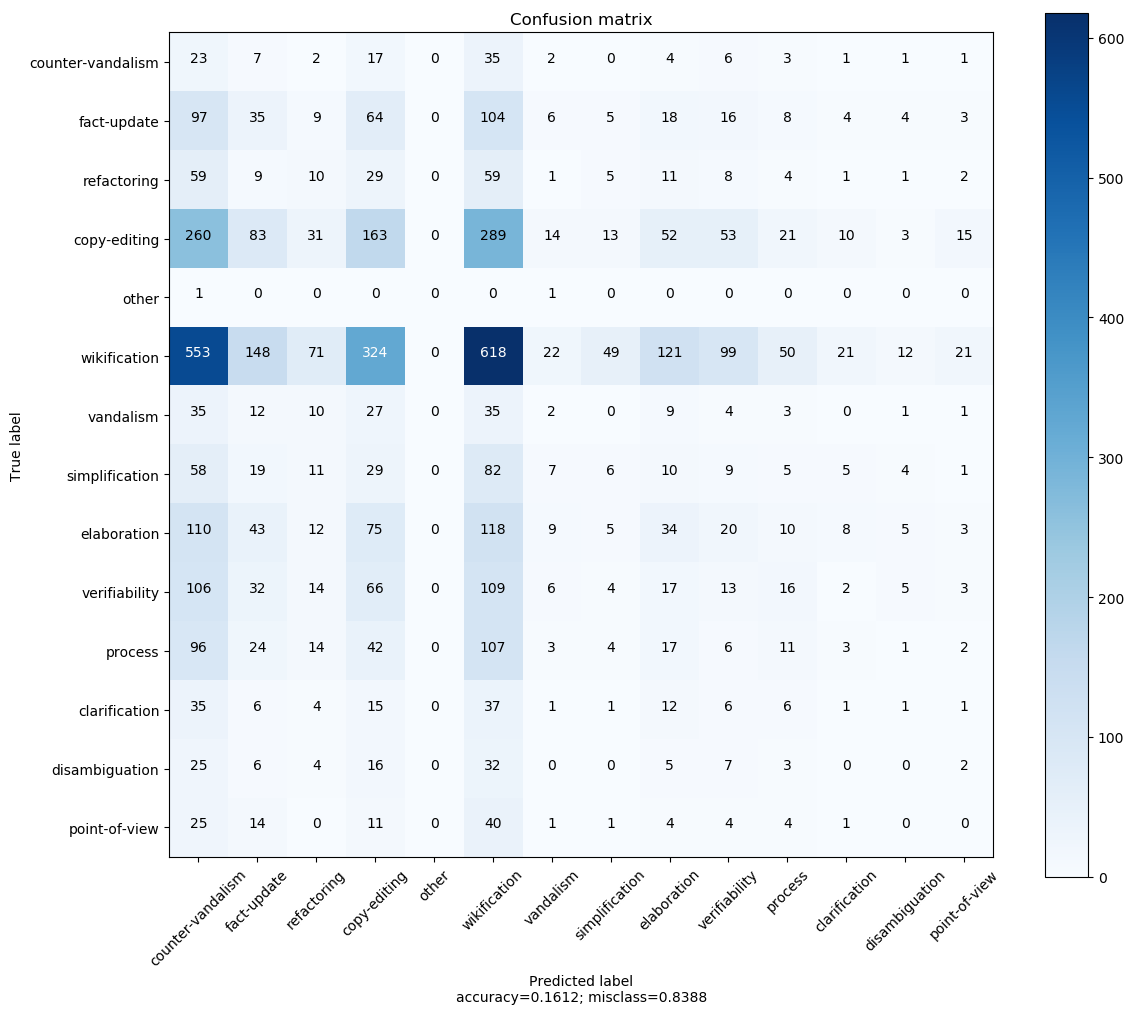

In [153]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix

clf = DummyClassifier(random_state = 64)

y_pred = cross_val_predict(clf, X, y, cv=4)

cm_ML_dummy = confusion_matrix(y.argmax(axis=1), y_pred.argmax(axis=1))

plot_confusion_matrix(cm_ML_dummy, intentions, normalize = False)


Clearly the results are not good, as we can see by its precision, recall and accuracy values. Also checking the confusion matrix we see how the principal diagonal is almost unnoticeanle with a misclasification of 0.87. Interestingly enough, "Counter-vandalism" is mistaken often for all the other intentions. The same issue arises with point of view and fact-update. The reasons behind this are unknown

In [154]:
base_rf_ML_data = pandas.DataFrame()


base_rf_ML_model = RandomForestClassifier(random_state = 64)
rf_ml_gs = GridSearchCV(base_rf_ML_model,
                    param_grid={},
                    scoring=scoring, cv=4, refit='micro', return_train_score=True)
rf_ml_gs.fit(X, y)
results = rf_ml_gs.cv_results_
    

base_rf_ML_data['Precision'] = [results['mean_test_Precision'][rf_ml_gs.best_index_]]
base_rf_ML_data['Recall'] = [results['mean_test_recall'][rf_ml_gs.best_index_]]
base_rf_ML_data['F1 micro'] = [results['mean_test_micro'][rf_ml_gs.best_index_]]
base_rf_ML_data['F1 macro'] = [results['mean_test_macro'][rf_ml_gs.best_index_]]
base_rf_ML_data['Accuracy'] = [results['mean_test_accuracy'][rf_ml_gs.best_index_]]
    
base_rf_ML_data.head(15)




,Precision,Recall,F1 micro,F1 macro,Accuracy
0,0.745522,0.444053,0.556922,0.31186,0.392926


The values while better than the baseline model are still low with a recall below 5 and an accuracy of only 39%

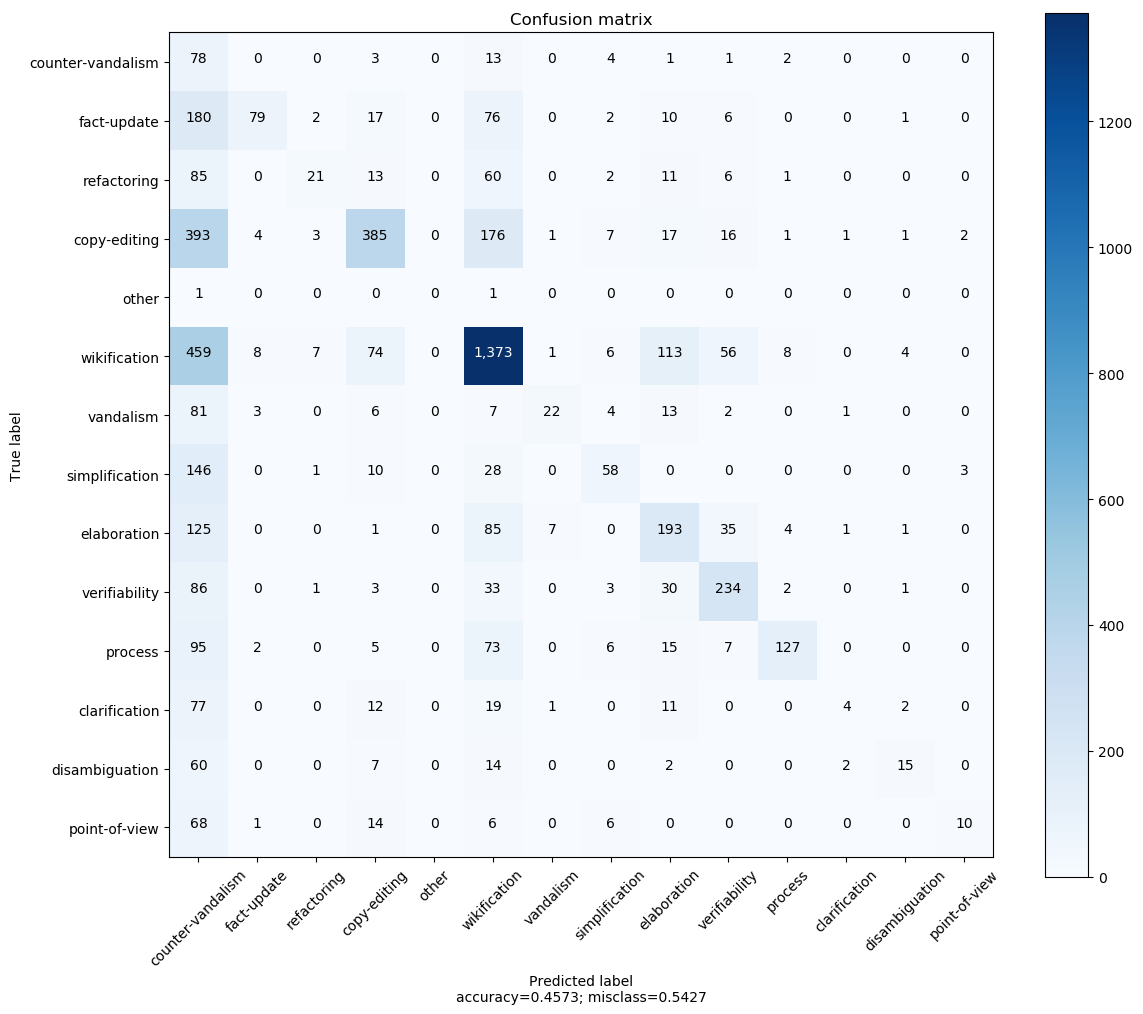

In [155]:
clf = RandomForestClassifier(random_state = 64)

y_pred = cross_val_predict(clf, X, y, cv=4)

cm_ML_rf = confusion_matrix(y.argmax(axis=1), y_pred.argmax(axis=1))

plot_confusion_matrix(cm_ML_rf, intentions, normalize = False)

The confusion matrix principal diagonal is still not very highlithed, meaning that while the results are better than the baseline model, the predictor is still weak. A misclasification of .54 means that pretty much half the predictions are wrong.

Like in the Dummy model, the intentions are often misclasiffied as counter vandalism or point of view.

In [156]:
base_KNN_ML_data = pandas.DataFrame()
  
base_KNN_ML_model = MLkNN()

knn_ml_gs = GridSearchCV(base_KNN_ML_model,
                    param_grid={},
                    scoring=scoring, cv=4, refit='micro', return_train_score=True)
knn_ml_gs.fit(X_scaled, y)
results = knn_ml_gs.cv_results_
    

base_KNN_ML_data['Precision'] = [results['mean_test_Precision'][knn_ml_gs.best_index_]]
base_KNN_ML_data['Recall'] = [results['mean_test_recall'][knn_ml_gs.best_index_]]
base_KNN_ML_data['F1 micro'] = [results['mean_test_micro'][knn_ml_gs.best_index_]]
base_KNN_ML_data['F1 macro'] = [results['mean_test_macro'][knn_ml_gs.best_index_]]
base_KNN_ML_data['Accuracy'] = [results['mean_test_accuracy'][knn_ml_gs.best_index_]]
    
base_KNN_ML_data.head(15)

,Precision,Recall,F1 micro,F1 macro,Accuracy
0,0.614699,0.416713,0.497729,0.289816,0.340665


As in the binary approach we used the scaled data in the KNN algorithm, however, the results are not as good as expected with a recall below 5 and an accuracy of 34%.

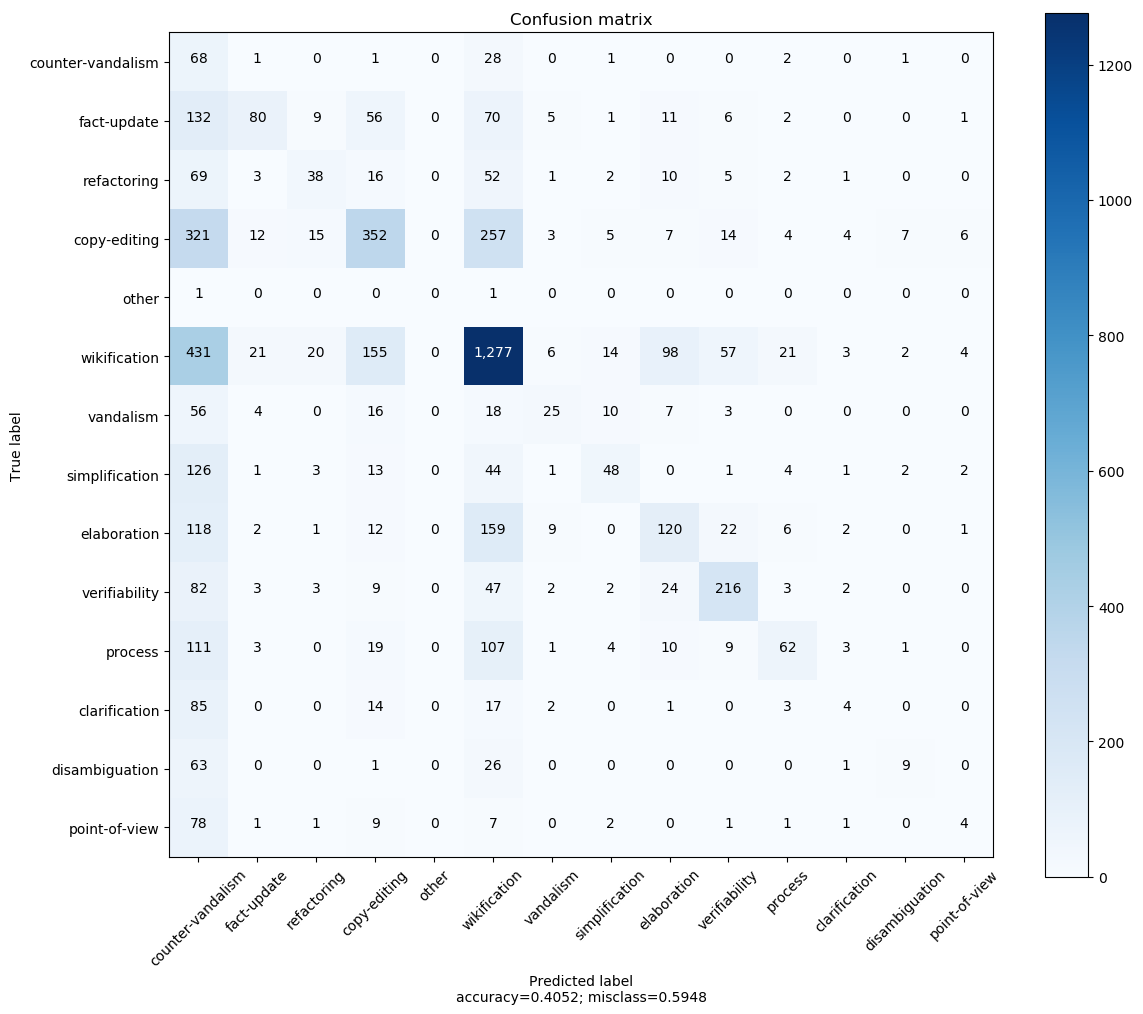

In [157]:
clf = MLkNN()

y_pred = cross_val_predict(clf, X_scaled, y, cv=4)

cm_ML_KNN = confusion_matrix(y.argmax(axis=1), y_pred.toarray().argmax(axis=1))

plot_confusion_matrix(cm_ML_KNN, intentions, normalize = False)

The confusion matrix is definetely similar to the one of the random forest, with similar values for each intention and also misclasifiying as point of view and counter vandalism all the other intentions.

In [158]:
base_models_ML_data_comp = pandas.DataFrame(index = dummy_ML_data.iloc[:,:].columns)

base_models_ML_data_comp['Dummy classifier'] = dummy_ML_data.as_matrix()[0,:]
base_models_ML_data_comp['Random Forest classifier'] = base_rf_ML_data.as_matrix()[0,:]
base_models_ML_data_comp['ML KNN'] = base_KNN_ML_data.as_matrix()[0,:]
base_models_ML_data_comp.head(15)

,Dummy classifier,Random Forest classifier,ML KNN
Precision,0.225337,0.745522,0.614699
Recall,0.209744,0.444053,0.416713
F1 micro,0.207030,0.556922,0.497729
F1 macro,0.087284,0.311860,0.289816
Accuracy,0.066338,0.392926,0.340665


Overall MLKNN and Random Forest performed similarly, with random forest slightly outperforming the Nearest Neighbors algorithm. However, the accuracy is still quite low and precision and recall values can still be improved.

As in the binary approach, we are going to apply feature engineering to the random forest to see if the different metric values increase. Feature engineering is not applied to the KNN as the model based approach cannot be applied with this algorithm.

In [159]:
base_rf_ML_fe_data = pandas.DataFrame()


rf_pipeline = Pipeline([
                        ('features', SelectFromModel(RandomForestClassifier(random_state = 64))),
                        ('classification', RandomForestClassifier(random_state = 64))
                        ])

gs_rf_fe = GridSearchCV(rf_pipeline, 
                        param_grid = {'features__threshold':['0.75*mean','mean','1.25*mean','1.5*mean']},
                        scoring = scoring, cv = 4, refit = 'micro', return_train_score = True)

gs_rf_fe.fit(X,y)
results = gs_rf_fe.cv_results_
    
base_rf_ML_fe_data['Precision'] = [results['mean_test_Precision'][gs_rf_fe.best_index_]]
base_rf_ML_fe_data['Recall'] = [results['mean_test_recall'][gs_rf_fe.best_index_]]
base_rf_ML_fe_data['F1 micro'] = [results['mean_test_micro'][gs_rf_fe.best_index_]]
base_rf_ML_fe_data['F1 macro'] = [results['mean_test_macro'][gs_rf_fe.best_index_]]
base_rf_ML_fe_data['Accuracy'] = [results['mean_test_accuracy'][gs_rf_fe.best_index_]]
base_rf_ML_fe_data['Threshold'] = gs_rf_fe.best_params_['features__threshold']
    
base_rf_ML_fe_data.head(15)



,Precision,Recall,F1 micro,F1 macro,Accuracy,Threshold
0,0.732163,0.439841,0.552965,0.316764,0.394158,0.75*mean


Results are pretty much the same, with a slight increase of f1 macro.

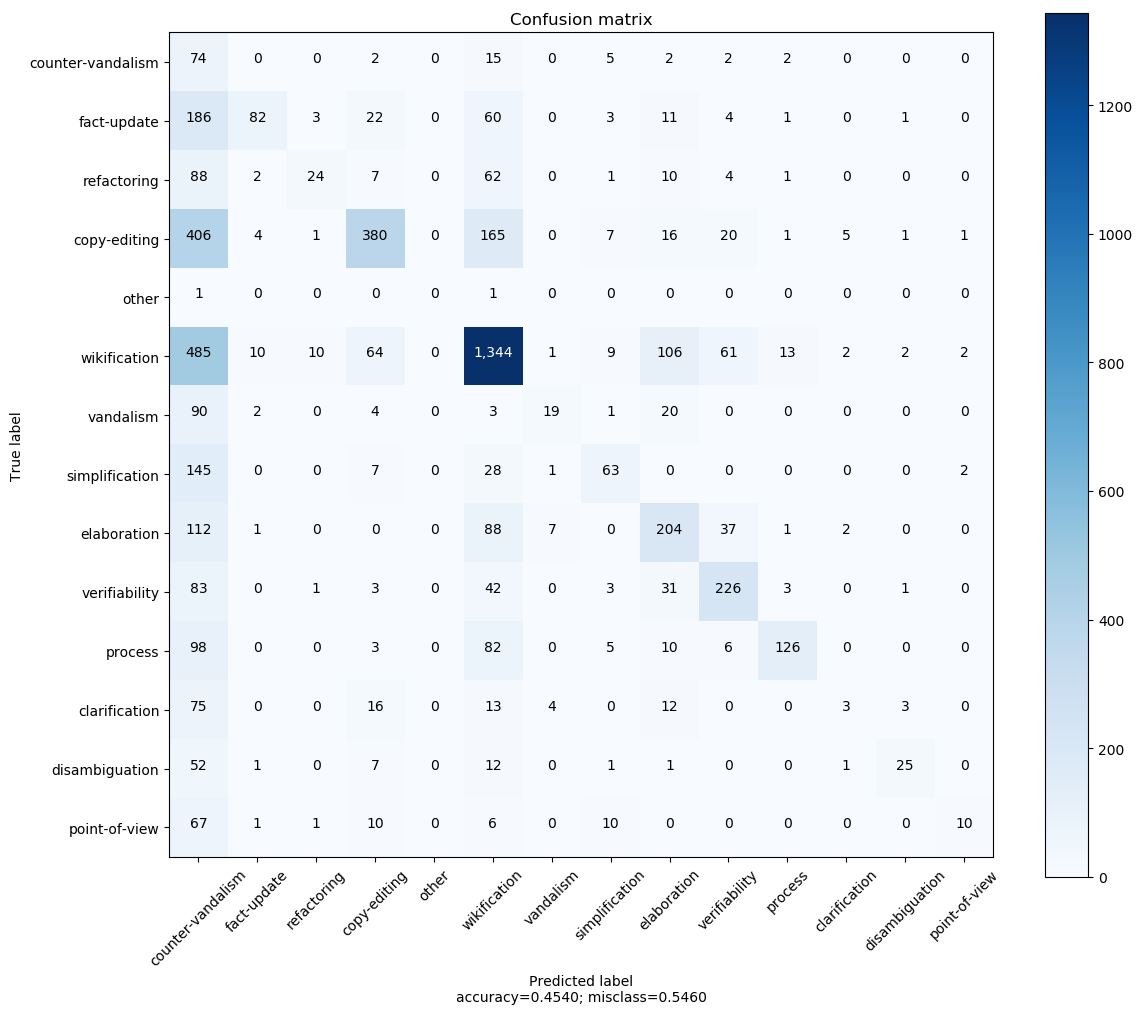

In [160]:
clf = rf_pipeline = Pipeline([
                        ('features', SelectFromModel(RandomForestClassifier(random_state = 64), threshold = gs_rf_fe.best_params_['features__threshold'] )),
                        ('classification', RandomForestClassifier(random_state = 64))
                        ])

y_pred = cross_val_predict(clf, X, y, cv=4)

cm_ML_rf_fe = confusion_matrix(y.argmax(axis=1), y_pred.argmax(axis=1))

plot_confusion_matrix(cm_ML_rf_fe, intentions, normalize = False)

Problem of counter-vandalism and point of view still happen. On the other hand, the matrix is quite the same as before applying the feature engineering.

In [161]:
base_models_ML_data_comp = pandas.DataFrame(index = dummy_ML_data.iloc[:,:].columns)

base_models_ML_data_comp['Dummy classifier'] = dummy_ML_data.as_matrix()[0,:]
base_models_ML_data_comp['Random Forest classifier'] = base_rf_ML_data.as_matrix()[0,:]
base_models_ML_data_comp['ML KNN'] = base_KNN_ML_data.as_matrix()[0,:]
base_models_ML_data_comp['RF with Feature Engineering'] = base_rf_ML_fe_data.as_matrix()[0,:len(base_rf_ML_fe_data.columns)-1]
base_models_ML_data_comp.head(15)

,Dummy classifier,Random Forest classifier,ML KNN,RF with Feature Engineering
Precision,0.225337,0.745522,0.614699,0.732163
Recall,0.209744,0.444053,0.416713,0.439841
F1 micro,0.207030,0.556922,0.497729,0.552965
F1 macro,0.087284,0.311860,0.289816,0.316764
Accuracy,0.066338,0.392926,0.340665,0.394158


Overall we see that the random forest performs better than the KNN, however its results are generally similar and as thus, both models will be tuned.

In [162]:
tuning_rf_ML_data = pandas.DataFrame()

pipeline = Pipeline([
                ('features', SelectFromModel(
                    RandomForestClassifier(random_state = 64))),
                ('classifier', RandomForestClassifier(random_state = 64))])

parameters_ML_RF = {'classifier__n_estimators' : [1,2,4,8,16,32,64,128,256,512],
                    'features__threshold' : ['0.75*mean','mean','1.25*mean','1.5*mean']}

grid_rf_ML = GridSearchCV(pipeline, 
                          parameters_ML_RF, 
                          cv = 4, scoring = scoring, refit = 'micro')
                    
#fitted on the train set specific for each intention
grid_rf_ML.fit(X,y)
                    
results = grid_rf_ML.cv_results_
    
tuning_rf_ML_data['Precision'] = [results['mean_test_Precision'][grid_rf_ML.best_index_]]
tuning_rf_ML_data['Recall'] = [results['mean_test_recall'][grid_rf_ML.best_index_]]
tuning_rf_ML_data['F1 micro'] = [results['mean_test_micro'][grid_rf_ML.best_index_]]
tuning_rf_ML_data['F1 macro'] = [results['mean_test_macro'][grid_rf_ML.best_index_]]
tuning_rf_ML_data['Accuracy'] = [results['mean_test_accuracy'][grid_rf_ML.best_index_]]
tuning_rf_ML_data['Threshold'] = grid_rf_ML.best_params_['features__threshold']
tuning_rf_ML_data['N estimators'] = grid_rf_ML.best_params_['classifier__n_estimators']


tuning_rf_ML_data.head(15)

,Precision,Recall,F1 micro,F1 macro,Accuracy,Threshold,N estimators
0,0.751177,0.484395,0.593395,0.333481,0.424776,0.75*mean,256


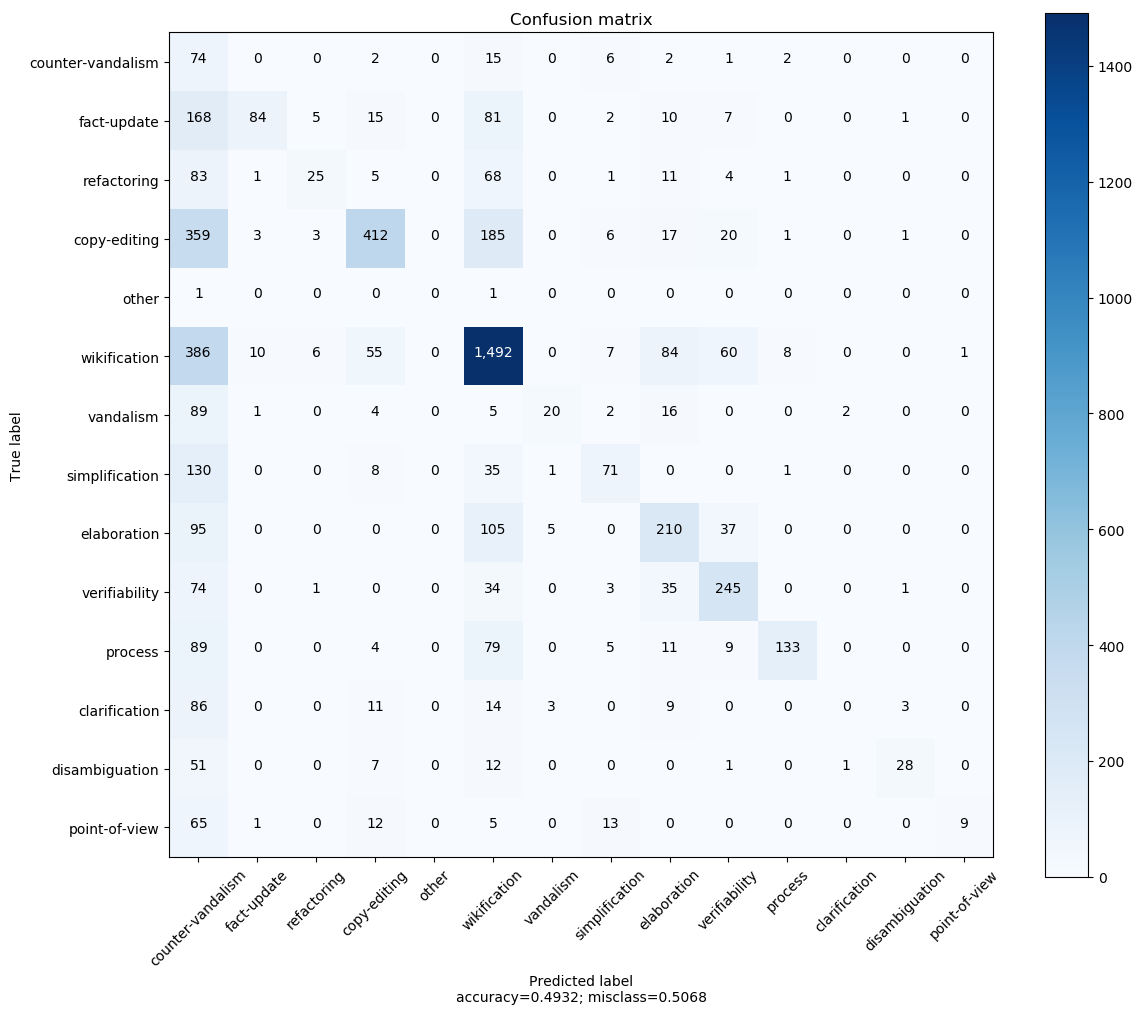

In [163]:
clf = rf_pipeline = Pipeline([
                        ('features', SelectFromModel(RandomForestClassifier(random_state = 64), threshold = grid_rf_ML.best_params_['features__threshold'] )),
                        ('classification', RandomForestClassifier(random_state = 64, n_estimators = grid_rf_ML.best_params_['classifier__n_estimators']))
                        ])

y_pred = cross_val_predict(clf, X, y, cv=4)

cm_ML_rf_tuning = confusion_matrix(y.argmax(axis=1), y_pred.argmax(axis=1))

plot_confusion_matrix(cm_ML_rf_tuning, intentions, normalize = False)

In [164]:
parameters_ML_KNN = {'k' : [1,2,3,4,5,6,7,8,9,10,15,20,25,30], 's' : [0.0001,0.001,0.01,0.1,1,10,100]}


tuning_KNN_ML_data = pandas.DataFrame()

grid_KNN_ML = GridSearchCV(MLkNN(), parameters_ML_KNN, cv = 4, scoring = scoring, refit = 'micro')
#fitted on the train set specific for each intention
grid_KNN_ML.fit(X_scaled,y)
grid_KNN_results = pandas.DataFrame(grid_KNN_ML.cv_results_) 

results = grid_rf_ML.cv_results_
    
tuning_KNN_ML_data['Precision'] = [results['mean_test_Precision'][grid_KNN_ML.best_index_]]
tuning_KNN_ML_data['Recall'] = [results['mean_test_recall'][grid_KNN_ML.best_index_]]
tuning_KNN_ML_data['F1 micro'] = [results['mean_test_micro'][grid_KNN_ML.best_index_]]
tuning_KNN_ML_data['F1 macro'] = [results['mean_test_macro'][grid_KNN_ML.best_index_]]
tuning_KNN_ML_data['Accuracy'] = [results['mean_test_accuracy'][grid_KNN_ML.best_index_]]
tuning_KNN_ML_data['N of neighbors'] = grid_KNN_ML.best_params_['k']
tuning_KNN_ML_data['Smoothing parameter'] = grid_KNN_ML.best_params_['s']


tuning_KNN_ML_data.head(15)

,Precision,Recall,F1 micro,F1 macro,Accuracy,N of neighbors,Smoothing parameter
0,0.739504,0.45947,0.570708,0.315149,0.402252,4,0.0001


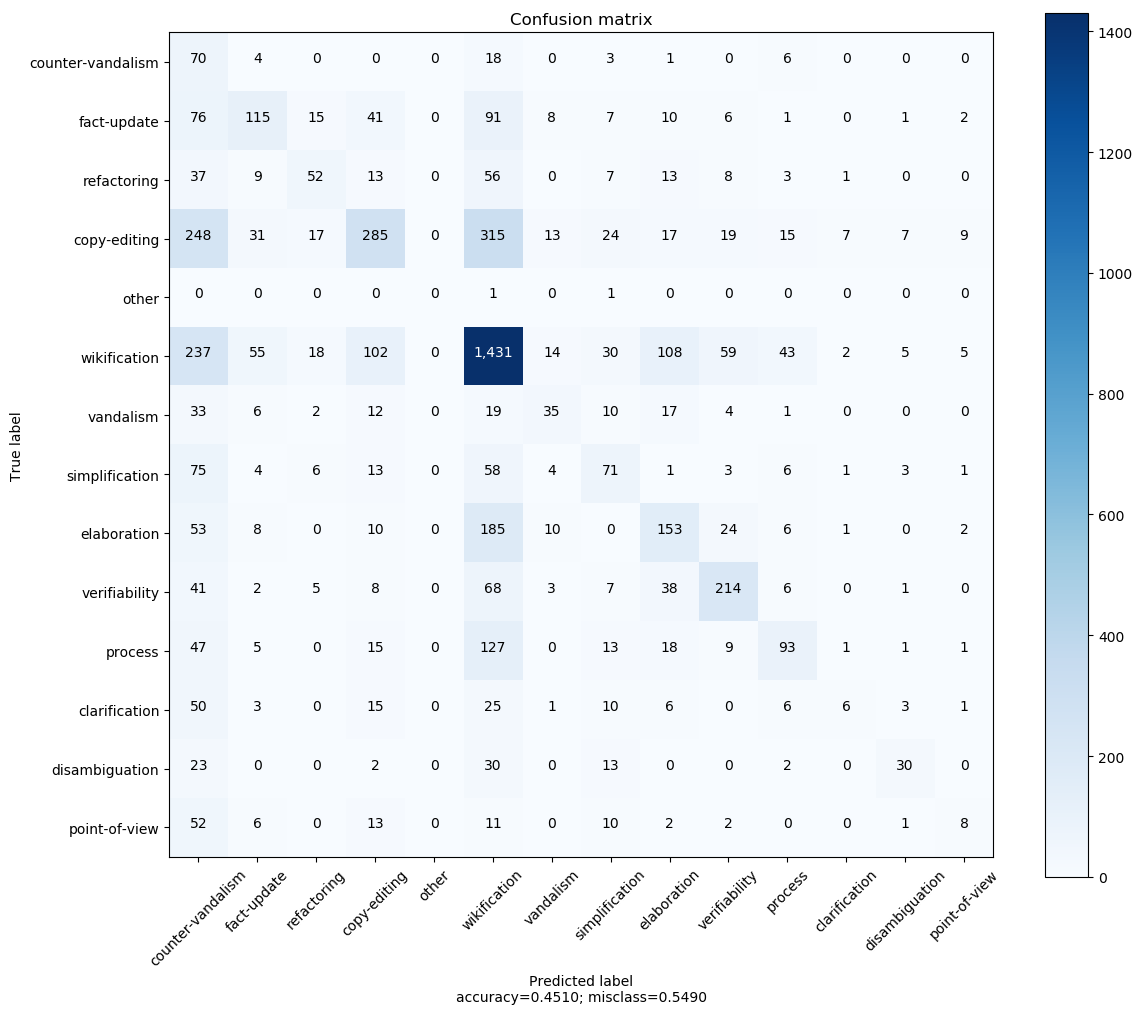

In [165]:
clf = MLkNN(k = grid_KNN_ML.best_params_['k'], s = grid_KNN_ML.best_params_['s'])

y_pred = cross_val_predict(clf, X_scaled, y, cv=4)

cm_ML_KNN_tuning = confusion_matrix(y.argmax(axis=1), y_pred.toarray().argmax(axis=1))

plot_confusion_matrix(cm_ML_KNN_tuning, intentions, normalize = False)

In [168]:
base_models_ML_data_comp = pandas.DataFrame(index = dummy_ML_data.iloc[:,:].columns)
base_models_ML_data_comp['Dummy classifier'] = dummy_ML_data.as_matrix()[0,:]
base_models_ML_data_comp['Random Forest classifier'] = base_rf_ML_data.as_matrix()[0,:]
base_models_ML_data_comp['ML KNN'] = base_KNN_ML_data.as_matrix()[0,:]
base_models_ML_data_comp['RF with Feature Engineering'] = base_rf_ML_fe_data.as_matrix()[0,: len(base_rf_ML_fe_data.columns)-1]
base_models_ML_data_comp['Tuned Random Forest with Feature Engineering'] = tuning_rf_ML_data.as_matrix()[0,:len(tuning_rf_ML_data.columns)-2]
base_models_ML_data_comp['Tuned MLKNN'] = tuning_KNN_ML_data.as_matrix()[0,:len(tuning_KNN_ML_data.columns)-2]
base_models_ML_data_comp.head(15)

,Dummy classifier,Random Forest classifier,ML KNN,RF with Feature Engineering,Tuned Random Forest with Feature Engineering,Tuned MLKNN
Precision,0.225337,0.745522,0.614699,0.732163,0.751177,0.739504
Recall,0.209744,0.444053,0.416713,0.439841,0.484395,0.459470
F1 micro,0.207030,0.556922,0.497729,0.552965,0.593395,0.570708
F1 macro,0.087284,0.311860,0.289816,0.316764,0.333481,0.315149
Accuracy,0.066338,0.392926,0.340665,0.394158,0.424776,0.402252


As we can see the tuning doesn't increase much the different metrics score. In both cases less than 50% of the intentions are predicted correctly making the model slightly useless

# Final conclusion

Now we compare the tuned models of both approached to determine which one gives the best results.

In [169]:
conclusion = pandas.DataFrame()
conclusion['Random Forest Binary approach'] = base_models_data_comp_fe['Tuned RF with OS and FE']
conclusion['Random Forest Multilabel approach'] = base_models_ML_data_comp['Tuned Random Forest with Feature Engineering']
conclusion['KNN Multilabel approach'] = base_models_ML_data_comp['Tuned MLKNN']
conclusion.head()

NameError: name 'base_models_data_comp_fe' is not defined

The values of the binary approach are averaged through all the intentions without considering each proportion in the dataset unlike the multilabel approach. As such the binary approach values are not the "real" values. However due to the big differences that can be appreciated in every metric, the slight different values that  with a weighted average would be reported would not make a difference. The winner is clearly the binary approach and as such those models will be exported and used for future classification of revisions.

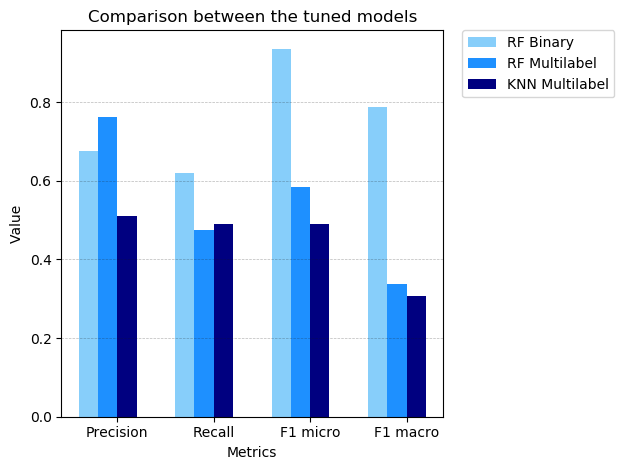

In [75]:
length = len(conclusion)
x_labels = ['Precision', 'Recall', 'F1 micro', 'F1 macro']
#['RF Binary', 'RF Multilabel', 'KNN Multilabel']
# Set plot parameters
fig, ax = plt.subplots()
width = 0.2 # width of bar
x = np.arange(length)

ax.bar(x, conclusion.iloc[:,0], width, color='#87CEFA', label='RF Binary')
ax.bar(x + width, conclusion.iloc[:,1], width, color='#1E90FF', label='RF Multilabel')
ax.bar(x + (2 * width), conclusion.iloc[:,2], width, color='#000080', label='KNN Multilabel')

ax.set_ylabel('Value')

ax.set_xticks(x + width + width/2)
ax.set_xticklabels(x_labels)
ax.set_xlabel('Metrics')
ax.set_title('Comparison between the tuned models')
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.grid(True, 'major', 'y', ls='--', lw=.5, c='k', alpha=.3)

fig.tight_layout()
plt.show()